| Field      | Units| Code | Frequency| Source  |Derivation Notes|
| :---        |    :----:   |    :---: |
|Total Debt - gross external debt as % of GDP|	%|	GGXWDG_NGDP|	Q|	QEDS|	
|Short-Term Debt - gross short-term external debt as % of GDP|	%|	DT.DOD.DSTC.ZS|	Q|	QEDS|	
|Real Interest Rate - lending interest rate adjusted for inflation|	%|	FILR_PA|	A/Q/M|	IMF - IFS|	To Derive - Subtract Inflation
|Foreign Exchange Reserves - total reserves (without gold) as % of GDP|	%|	RAXGFX_USD|	A/Q/M|	IMF - IFS|	To Derive
|Trade Openness - ratio of exports plus imports to GDP|	Unitless|	(TXG_FOB_USD + TMG_CIF_USD)/GDP|	Q|	IMF - IFS|	
|Imports - imports of goods and services at current prices in USD|	USD|	TMG_CIF_USD|	A/Q/M|	IMF - IFS|	
|Exports - exports of goods and services at current prices in USD|	USD|	TXG_FOB_USD|	A/Q/M|	IMF - IFS|	
|Current Account - current account balance as % of GDP|	%|	BCAXF_BP6_USD|	A/Q|	IMF - BOP|	
|Portfolio Investments - portfolio investment net at current USD|	USD|	IAP_BP6_USD|	A/Q|	IMF - IFS|	
|FDI - net FDI inflows as % of GDP|	USD|	BFDLXF_BP6_USD|	A/Q|	IMF - BOP|	To Derive
|Real GDP - annual real GDP at current USD|	USD|	NY.GDP.MKTP.CD|	A|	WDI|	To Derive: Will have to divide by 4 for Q, 12 for M, 365 for D
|Real GDP Growth - annual growth of real GDP|	|	just make it - WILL THIS BE USEFUL?!|	|	|	Not Required
|Inflation - rate of change in CPI|	%|	PCPI_IX|	A/Q/M|	IMF - CPI|	
|M2 - Money plus quasi-money, Domestic Currency|	XDC|	35L___XDC|	A/Q/M|	IMF - IFS|	used in derivaion
|M2 Multiplier Growth - annual growth of M2|	%|	FM.LBL.BMNY.ZG|	A|	WDI|	To Derive M2
|Reserves - Total Reserves excluding Gold, US Dollars|	USD|	RAXG_USD|	A/Q/M|	IMF - IFS|	used in derivaion
|M2/Reserves - ratio of M2 to foreign exchange reserves|	XCD*FX/USD|	FM.LBL.BMNY.IR.ZS(FM.LBL.BMNY.IR.ZS_DS2)|	A|	WDI|	
|REER Overall - deviation of real effective exchange rate from 5 year rolling mean|	Unitless|	EREER_IX|	A/Q/M|	WDI|	Need to derived the 5 year period average 
|Government Spending - general government final spending as % of GDP|	%|	GGX_NGDP|	A|	World Bank|	Need to Take it from the CVS Annually
|Fixed Capital Formation - gross fixed capital formation at current USD|	USD|	NE.GDI.FTOT.CD|	A|	WDI|	
|Unemployment - unemployment total as % of total labor force|	%|	LUR_PT|	A/Q|	IMF - IFS|	
|Contagion - event of a currency crisis in any country of the same region (t − 1)|	Indicator|	|	|	Derived|	
|Domestic Credit - ratio of domestic credit to GDP|	%/(USD)|	32____XDC|	A/Q/M|	IMF - IFS|	Divide by GDP
|Lending Interest Rate - the bank rate meets the short- and medium-term financing needs|	%|	FILR_PA|	A/Q/M|	IMF - IFS|	
|Deposit Interest Rate - rate paid by banks for demand, time, or savings deposits|	%|	FIDR_PA|	A/Q/M|	IMF - IFS|	




In [1]:
!pip install -q -r requirements.txt
import pandas as pd
import numpy as np


from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split

import datapackage
from functools import reduce
import world_bank_data as wb
import requests
import quandl
quandl.ApiConfig.api_key = "bu8h2aStGXk6JxZRbQd9"
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.express as px
#import tabula
#from tabula import read_pdf

In [47]:
indicators = wb.get_indicators().reset_index()

#indicators[indicators['id'].str.contains('NE.GDI.FTOT.CD')]
indicators[indicators['id'].str.contains('GC.DOD.TOTL.GD.ZS')]

id                                       name unit  \
7169  GC.DOD.TOTL.GD.ZS  Central government debt, total (% of GDP)        

                            source  \
7169  World Development Indicators   

                                             sourceNote  \
7169  Debt is the entire stock of direct government ...   

                                     sourceOrganization  \
7169  International Monetary Fund, Government Financ...   

                               topics  
7169  Economy & Growth,Public Sector

# Data Cleaning function

In [46]:
def clean_wdi_data(dataset, countries, date_from = 1980, date_to = 2020 ):
    '''
    Loads WOE CSV 
    dataset {df}: WDI Data sample
    countries {List}: List of countries to be inclided in Dataset
    date_from {int}: Lowest year - default 1980
    date_to {int}: Highest Yeat - default 2020

    Output{df}: Year, Country Name , Country Code, [Series Names]

    '''
    #Clean titles
    #Create Dictionary of column header mapping & use rename function
    old_columns = dataset.columns[4::]
    yr_columns = dataset.columns[4::].str[:4]
    yr_columns_dict = dict(zip(old_columns, yr_columns))
    dataset.rename(columns = yr_columns_dict, inplace = True)
    
    #Country Selection
    dataset = dataset[dataset['Country Name'].isin(countries)].copy()
    
    #Reform Pivotted Data
    dataset.drop([ 'Series Code'], axis=1, inplace = True)
    dataset = dataset.melt(id_vars=['Country Name','Country Code','Series Name'], var_name='Year', value_name='Value' ).copy()
    dataset = dataset.pivot(index=['Year', 'Country Name', 'Country Code'], columns='Series Name', values='Value').reset_index().copy()
    dataset.rename(columns = {'Country Code':'ISO Code'}, inplace = True)

    return dataset

def clean_IFS_data(dataset, countries, frequency, date_from, Series_Codes , date_to):
    '''
    Loads IFS CSV 
    dataset {df}: WDI Data sample
    countries {List}: List of countries to be inclided in Dataset
    date_from {int}: Lowest year - default 1980
    date_to {int}: Highest Yeat - default 2020

    Output{df}: 'Year', 'Country Name', 'Country Code', [Series Names]

    '''
    #Country Selection
    dataset = dataset[dataset['Country Name'].isin(countries)].copy()   

    #Concat Base year & Drop Base Year Column
    dataset['Indicator Name'] = np.where(dataset['Base Year'].isnull(),dataset['Indicator Name'], dataset['Indicator Name'] + " (" + dataset['Base Year'] +")").copy()
    
    # Filter by then concat the Indicator Code
    dataset = dataset[dataset['Indicator Code'].isin(Series_Codes)].copy()
    dataset['Indicator Name'] = dataset['Indicator Name'] + " - " + dataset['Indicator Code']

    dataset = dataset[dataset['Attribute']!='Status'].copy()
    
    dataset.drop(['Base Year', 'Indicator Code', 'Attribute'], axis=1, inplace = True)


    #Melt Data 
    dataset = dataset.melt(id_vars=['Country Name','Country Code','Indicator Name'], var_name='Year', value_name='Value' ).copy()

    #Frequency - Annual - Done
    if frequency == 'Y':
        non_ann = ['M', 'Q']
        dataset = dataset[~dataset.Year.str.contains('|'.join(non_ann))].copy()
    elif frequency == 'Q':
        dataset = dataset[dataset.Year.str.contains('Q')].copy()
    elif frequency == 'M':
        dataset = dataset[dataset.Year.str.contains('M')].copy()

    #Pivot Indicators to Columns
    dataset['Value'] = dataset['Value'].astype(float)
    dataset = dataset.groupby(['Year', 'Country Name', 'Country Code', 'Indicator Name']).agg({'Value':'sum'}).reset_index().copy()
    dataset = dataset.pivot(index=['Year', 'Country Name', 'Country Code'], columns='Indicator Name', values='Value').reset_index().copy()
    dataset.rename(columns = {'Country Code':'IMF Code'}, inplace = True)

    return dataset


# Generic API Functions

## Single Column Calls

In [69]:
def Call_IMF(DB,freq,Country_iso2, start, finish, Indicator_code):
    '''
    Returns "Year" & "Values" of series with column names after the IMF Code
    '''
    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    key = f'{DB}/{freq}.{Country_iso2}.{Indicator_code}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    url = f'{core}{key}{time}'

    # Get data from the above URL using the requests package
    data = requests.get(url).json()

    # Load data into a pandas dataframe
    series = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    series['@OBS_VALUE'] = series['@OBS_VALUE'].astype(float)
    series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':Indicator_code}, inplace = True)
    return series

def Call_WB(iso3, id,start, finish):
    '''
    Returns "Country"(ISO3), "Year" & "Values" of series with column names after the World Bank Code
    '''
    daterange = f'{start}:{finish}'
    Data = pd.DataFrame(wb.get_series(id, date=daterange, id_or_value='id', simplify_index=True)).reset_index()
    Data = Data[Data['Country']==iso3]
    return Data


def Get_Monthly_GDP(iso3,start, finish):
    '''
    Returns Monthly Call_WB()
    '''
    Data = Call_WB(iso3=iso3, id='NY.GDP.MKTP.CD',start=start, finish=(finish+1))
    Data['Year'] = pd.to_datetime(Data['Year'], exact = False, format='%Y%')
    Data.set_index(['Year'],inplace=True)
    Data.drop(columns='Country', inplace = True)
    Data['GDP % Increase'] = 100*Data['NY.GDP.MKTP.CD'].pct_change()
    Data = Data.resample('MS').ffill() / 12
    Data = Data.reset_index()

    return Data
def Get_Quarterly_GDP(iso3,start, finish):
    '''
    Returns Monthly Call_WB()
    '''
    Data = Call_WB(iso3=iso3, id='NY.GDP.MKTP.CD',start=start, finish=(finish+1))
    Data['Year'] = pd.to_datetime(Data['Year'], exact = False, format='%Y%')
    Data.set_index(['Year'],inplace=True)
    Data.drop(columns='Country', inplace = True)
    Data = Data.resample('QS').ffill() / 4
    Data = Data.reset_index()

    return Data
def Get_Monthly_QEDS(iso3,start, finish):
    '''
    Returns Monthly Call_WB()
    '''
    dfs = [ Call_WB(iso3=iso3, id='DP.DOD.DECN.CR.GG.Z1',start=start, finish=(finish+1)), #Total_Debt
            Call_WB(iso3=iso3, id='DP.DOD.DSTC.CR.GG.Z1',start=start, finish=(finish+1))] #Shrt_Trm_Debt

    Data = reduce(lambda  left,right: pd.merge(left,right,on=['Year', 'Country'],how='outer'), dfs).fillna(np.NaN)
    
    start_date = pd.to_datetime(start, format = '%Y')
    end_date = pd.to_datetime(finish, format = '%Y')

    #Change to quarter start
    Data['Year'] = pd.to_datetime(Data['Year'])
    Data.set_index(['Year'],inplace=True)
    Data = Data.loc[start_date:end_date].copy()
    Data.drop(columns='Country', inplace = True)
    Data = Data.resample('MS').bfill()
    Data = Data.reset_index()

    return Data

def QEDS(iso3,start, finish):
    '''
    Returns quarterly Call_WB()
    '''
    dfs = [ Call_WB(iso3=iso3, id='DP.DOD.DECN.CR.GG.Z1',start=start, finish=(finish+1)), #Total_Debt
            Call_WB(iso3=iso3, id='DP.DOD.DSTC.CR.GG.Z1',start=start, finish=(finish+1))] #Shrt_Trm_Debt

    Data = reduce(lambda  left,right: pd.merge(left,right,on=['Year', 'Country'],how='outer'), dfs).fillna(np.NaN)
    
    start_date = pd.to_datetime(start, format = '%Y')
    end_date = pd.to_datetime(finish, format = '%Y')

    #Change to quarter start
    Data['Year'] = pd.to_datetime(Data['Year'])
    Data.set_index(['Year'],inplace=True)
    Data = Data.loc[start_date:end_date].copy()
    Data.drop(columns='Country', inplace = True)
    return Data


def Call_M_IMF(iso2, start, finish):
    mth_fields = ['RAXGFX_USD','TMG_CIF_USD','TXG_FOB_USD','PCPI_IX',
                '35L___XDC','RAXG_USD','EREER_IX','32____XDC','FILR_PA','FIDR_PA','ENDA_XDC_USD_RATE']
    
    call_string = "+".join(mth_fields)    
    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    key = f'IFS/M.{iso2}.{call_string}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    url = f'{core}{key}{time}'

    # Get data from the above URL using the requests package
    data = requests.get(url).json()
    # Load data into a pandas dataframe
    #series = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    appended_data = []
    num_rows = pd.DataFrame(data['CompactData']['DataSet']['Series']).shape[0]
    #print(pd.DataFrame(data['CompactData']['DataSet']['Series']))
    for c in range(num_rows):
        header = data['CompactData']['DataSet']['Series'][c]['@INDICATOR']
        #print(header)
        unit_mult = float(data['CompactData']['DataSet']['Series'][c]['@UNIT_MULT'])
        series = pd.DataFrame(data['CompactData']['DataSet']['Series'][c]['Obs'])
        series['@OBS_VALUE']=series['@OBS_VALUE'].astype(float)
        if unit_mult != 0:
            series['@OBS_VALUE'] = series['@OBS_VALUE']*(10**unit_mult)

        series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':header}, inplace = True)
        series['Year'] = pd.to_datetime(series['Year'], exact = False, format='%Y%')
        appended_data.append(series)

    #Add GDP Data
    WB_countries = wb.get_countries().reset_index()
    iso3 = WB_countries['id'][WB_countries['iso2Code']==iso2].item()
    region = WB_countries['region'][WB_countries['iso2Code']==iso2].item()
    appended_data.append(Get_Monthly_GDP(iso3,start, finish))
    merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],how='outer'), appended_data).fillna(np.NaN)

    #Add Derived Monthly GDP Date
    

    #Create Derived Fields
    #Real interest rate adjusted to inflation
    if 'FILR_PA' in merged_df.columns and 'PCPI_IX' in merged_df.columns:
        merged_df['Real Interest Rate(%)'] = merged_df['FILR_PA'] - merged_df['PCPI_IX']
    #total reserves (without gold) as % of GDP
    if 'RAXGFX_USD' in merged_df.columns and 'NY.GDP.MKTP.CD' in merged_df.columns:
        merged_df['Foreign Exchange Reserves(%)'] = 100*(merged_df['RAXGFX_USD']/ (merged_df['NY.GDP.MKTP.CD']))
    #M2 Multiplier Growth
    if '35L___XDC' in merged_df.columns:
        merged_df['M2 Multiplier Growth (%)'] = 100*(merged_df['35L___XDC'].pct_change())
    #'M2/Reserves'
    if '35L___XDC' in merged_df.columns and 'RAXGFX_USD' in merged_df.columns and 'ENDA_XDC_USD_RATE' in merged_df.columns:
        merged_df['M2/Reserves'] = merged_df['35L___XDC']/(merged_df['RAXGFX_USD']*merged_df['ENDA_XDC_USD_RATE'])
    #1 year Deviation of REED
    if 'EREER_IX' in merged_df.columns:
        merged_df['REED 12mth std dev'] = merged_df['EREER_IX'].rolling(12).std()
    #Domestic Credit to GDP
    if '32____XDC' in merged_df.columns and 'NY.GDP.MKTP.CD' in merged_df.columns and 'ENDA_XDC_USD_RATE' in merged_df.columns:
        merged_df['Domestic Credit to GDP'] = (merged_df['32____XDC']/(merged_df['NY.GDP.MKTP.CD']*merged_df['ENDA_XDC_USD_RATE']))
    #Trade Openness 
    if 'TXG_FOB_USD' in merged_df.columns and 'NY.GDP.MKTP.CD' in merged_df.columns and 'TMG_CIF_USD' in merged_df.columns:
        merged_df['Trade Openness'] = (merged_df['TXG_FOB_USD']+ merged_df['TMG_CIF_USD'])/(merged_df['NY.GDP.MKTP.CD'])

    #Classify the Data   
    if 'ENDA_XDC_USD_RATE' in merged_df.columns:
        merged_df['% Diff'] = (100*merged_df['ENDA_XDC_USD_RATE'].pct_change(periods = 3)).round(6) 
        #cut_labels = ['normal behaviour', 'Low', 'Medium', 'High']
        cut_labels = [0,1,2,3]
        regions = pd.DataFrame({'region':['East Asia & Pacific', 'Europe & Central Asia','Latin America & Caribbean ', 'South Asia','Sub-Saharan Africa '],
                        'Level_1':[5,10,7.5,5,5],
                        'Level_2':[10,15,12.5,10,10],
                        'Level_3':[15,20,17.5,15,15]
                        })
        regions = regions[regions['region']==region]
        min_move = merged_df['% Diff'].min()
        max_move = merged_df['% Diff'].max()
        if regions['Level_3'][regions['region']==region].item() > max_move:
            max_move = regions['Level_3'][regions['region']==region].item() + 1
        
        cuts = [min_move,
                regions['Level_1'][regions['region']==region].item(),
                regions['Level_2'][regions['region']==region].item(),
                regions['Level_3'][regions['region']==region].item(),
                max_move]
        merged_df['Class'] = pd.cut(merged_df['% Diff'],bins=cuts,labels=cut_labels)
        cond_1 = merged_df['Class'].isna()
        cond_2 = merged_df['% Diff'] <  regions['Level_1'][regions['region']==region].item() 
        merged_df['Class'] = np.where(cond_1 & cond_2,0, merged_df['Class']) # normal behaviour fill

    to_drop = ['RAXGFX_USD','35L___XDC','RAXG_USD','EREER_IX','32____XDC','@OBS_STATUS','% Diff']
    filtered_list = [col for col in to_drop if col  in merged_df.columns.to_list() ]
    merged_df.drop(columns =filtered_list, inplace = True )

    merged_df['days in month']  = pd.to_datetime(merged_df['Year']).dt.to_period('M').dt.days_in_month
    
    merged_df.set_index('Year', inplace = True)
    merged_df = merged_df.resample('D').pad()
    split = ['TMG_CIF_USD','TXG_FOB_USD','M2 Multiplier Growth','GDP % Increase']

    for i in range(len(split)):
        if split[i] in merged_df.columns.to_list():
            merged_df[split[i]] = merged_df[split[i]] / merged_df['days in month']
    merged_df.drop(columns =('days in month'), inplace = True )

    return merged_df


def Call_Q_IMF(iso2,start, finish):
    IFS_fields = ['IAP_BP6_USD','LUR_PT',]
    BOP_fields = ['BCAXF_BP6_USD','BFDLXF_BP6_USD']

    IFS_string = "+".join(IFS_fields)
    BOP_string = "+".join(BOP_fields)

    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    IFS_key = f'IFS/Q.{iso2}.{IFS_string}'
    BOP_key = f'IFS/Q.{iso2}.{BOP_string}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    IFS_url = f'{core}{IFS_key}{time}'
    BOP_url = f'{core}{BOP_key}{time}'

    # Get data from the above URL using the requests package
    IFS_data = requests.get(IFS_url).json()
    BOP_data = requests.get(BOP_url).json()
    # Load data into a pandas dataframe
    
    appended_data = []
    
    
    #IFS DATA
    num_rows = pd.DataFrame(IFS_data['CompactData']['DataSet']['Series']).shape[0]
    #print(pd.DataFrame(IFS_data['CompactData']['DataSet']['Series']))
    for c in range(num_rows):
        header = IFS_data['CompactData']['DataSet']['Series'][c]['@INDICATOR']
        #print(header)
        unit_mult = float(IFS_data['CompactData']['DataSet']['Series'][c]['@UNIT_MULT'])
        series = pd.DataFrame(IFS_data['CompactData']['DataSet']['Series'][c]['Obs'])
        series['@OBS_VALUE']=series['@OBS_VALUE'].astype(float)
        if unit_mult != 0:
            series['@OBS_VALUE'] = series['@OBS_VALUE']*(10**unit_mult)

        series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':header}, inplace = True)
        series['Year'] = pd.PeriodIndex(series['Year'], freq='Q').to_timestamp()
        appended_data.append(series)
    #BOP DATA
    num_rows = pd.DataFrame(BOP_data['CompactData']['DataSet']['Series']).shape[0]
    #print(pd.DataFrame(BOP_data['CompactData']['DataSet']['Series']))
    for c in range(num_rows):
        header = BOP_data['CompactData']['DataSet']['Series'][c]['@INDICATOR']
        #print(header)
        unit_mult = float(BOP_data['CompactData']['DataSet']['Series'][c]['@UNIT_MULT'])
        series = pd.DataFrame(BOP_data['CompactData']['DataSet']['Series'][c]['Obs'])
        series['@OBS_VALUE']=series['@OBS_VALUE'].astype(float)
        if unit_mult != 0:
            series['@OBS_VALUE'] = series['@OBS_VALUE']*(10**unit_mult)

        series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':header}, inplace = True)
        series['Year'] = pd.PeriodIndex(series['Year'], freq='Q').to_timestamp()
        appended_data.append(series)



    #Add GDP Data
    WB_countries = wb.get_countries().reset_index()
    iso3 = WB_countries['id'][WB_countries['iso2Code']==iso2].item()
    appended_data.append(Get_Quarterly_GDP(iso3,start, finish))
    merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],how='outer'), appended_data).fillna(np.NaN)

    #Add Derived GDP Date


    #Create Derived Fields
    #net FDI inflows as % of GDP
    if 'BFDLXF_BP6_USD' in merged_df.columns and 'NY.GDP.MKTP.CD' in merged_df.columns:
        merged_df['FDI as % of GDP(%)'] = 100*(merged_df['BFDLXF_BP6_USD'] / merged_df['NY.GDP.MKTP.CD'])
    #current account balance as % of GDP
    if 'BCAXF_BP6_USD' in merged_df.columns and 'NY.GDP.MKTP.CD' in merged_df.columns and 'NY.GDP.MKTP.CD' in merged_df.columns:
        merged_df['Foreign Exchange Reserves(%)'] = 100*(merged_df['BCAXF_BP6_USD']/ merged_df['NY.GDP.MKTP.CD'])


    to_drop = ['BFDLXF_BP6_USD','BCAXF_BP6_USD','NY.GDP.MKTP.CD','EREER_IX','32____XDC','@OBS_STATUS']


    filtered_list = [col for col in to_drop if col  in merged_df.columns.to_list() ]
    filtered_list+=[col for col in merged_df.columns if 'OBS_STATUS' in col]
    merged_df.drop(columns =filtered_list, inplace = True )
    
    #Turn to Monthly & add QEDS Data
    merged_df.set_index('Year', inplace = True)
    merged_df = merged_df.resample('MS').ffill().reset_index()
    if  'IAP_BP6_USD' in merged_df.columns:
        #Linear USD Split to monthly data
        merged_df['IAP_BP6_USD'] = merged_df['IAP_BP6_USD']/3
    merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],how='outer'), [merged_df,Get_Monthly_QEDS(iso3,start=start, finish=finish)]).fillna(np.NaN)
    
    #Turn Data from monthly to daily
    merged_df['days in month']  = pd.to_datetime(merged_df['Year']).dt.to_period('M').dt.days_in_month
    merged_df.set_index('Year', inplace = True)
    merged_df = merged_df.resample('D').pad()
    if  'IAP_BP6_USD' in merged_df.columns:
        #Linear USD Split to monthly data
        merged_df['IAP_BP6_USD'] = merged_df['IAP_BP6_USD']/ merged_df['days in month']
    merged_df.drop(columns =('days in month'), inplace = True )
    return merged_df

def join_data(iso2,start, finish):
    merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],how='outer'), [Call_Q_IMF(iso2=iso2,start=start, finish=finish).reset_index(), Call_M_IMF(iso2=iso2,start=start, finish=finish).reset_index()]).fillna(np.NaN)
    merged_df.set_index('Year', inplace = True)
    return merged_df

def Annual_GDP(iso3, start, finish):
    '''
    Returns Annual Call_WB()
    '''
    Data = Call_WB(iso3=iso3, id='NY.GDP.MKTP.CD',start=start, finish=(finish+1))
    Data['Year'] = pd.to_datetime(Data['Year'], exact = False, format='%Y%')
    Data.set_index(['Year'],inplace=True)
    Data.drop(columns='Country', inplace = True)
    Data = Add_datetimes(Data, wave = 'N')
    Data = Data.reset_index()
    return Data
    
def MacEcon_M_TS(iso2, start, finish):
    '''
    in: iso2 = country you want, start = beginning data, finish = final year
    out: DF with Monthly time series of Macro economic features with Year, month num, Day of month) 
    '''
    mth_fields = ['RAXGFX_USD','TMG_CIF_USD','TXG_FOB_USD','PCPI_IX',
                '35L___XDC','RAXG_USD','EREER_IX','32____XDC','FILR_PA','FIDR_PA','ENDA_XDC_USD_RATE']
    
    call_string = "+".join(mth_fields)    
    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    key = f'IFS/M.{iso2}.{call_string}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    url = f'{core}{key}{time}'

    # Get data from the above URL using the requests package
    data = requests.get(url).json()
    # Load data into a pandas dataframe
    #series = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    appended_data = []
    num_rows = pd.DataFrame(data['CompactData']['DataSet']['Series']).shape[0]
    #print(pd.DataFrame(data['CompactData']['DataSet']['Series']))
    for c in range(num_rows):
        header = data['CompactData']['DataSet']['Series'][c]['@INDICATOR']
        #print(header)
        unit_mult = float(data['CompactData']['DataSet']['Series'][c]['@UNIT_MULT'])
        series = pd.DataFrame(data['CompactData']['DataSet']['Series'][c]['Obs'])
        series['@OBS_VALUE']=series['@OBS_VALUE'].astype(float)
        if unit_mult != 0:
            series['@OBS_VALUE'] = series['@OBS_VALUE']*(10**unit_mult)

        series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':header}, inplace = True)
        series['Year'] = pd.to_datetime(series['Year'], exact = False, format='%Y%')
        appended_data.append(series)
    monthly_data = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],how='outer'), appended_data).fillna(np.NaN)
    monthly_data.set_index('Year', inplace = True)
    monthly_data = Add_datetimes(monthly_data, wave = 'N')
    monthly_data.drop(columns = ('DoM'), inplace = True)
    
    #Add GDP Data
    WB_countries = wb.get_countries().reset_index()
    iso3 = WB_countries['id'][WB_countries['iso2Code']==iso2].item()
    region = WB_countries['region'][WB_countries['iso2Code']==iso2].item()
    GDP = Annual_GDP(iso3,start, finish)
    GDP.drop(columns = ('MoY'), inplace = True)
    appended_data = [monthly_data, GDP]
    merged_df = reduce(lambda  left,right: pd.merge(left,right,on=['Yr'],how='outer'), appended_data).fillna(np.NaN)
    merged_df.drop(columns = (['DoM','@OBS_STATUS']), inplace = True)
    
    return merged_df


def MacEcon_Q_TS(iso2,start, finish):
    IFS_fields = ['IAP_BP6_USD','LUR_PT',]
    BOP_fields = ['BCAXF_BP6_USD','BFDLXF_BP6_USD']

    IFS_string = "+".join(IFS_fields)
    BOP_string = "+".join(BOP_fields)

    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    IFS_key = f'IFS/Q.{iso2}.{IFS_string}'
    BOP_key = f'IFS/Q.{iso2}.{BOP_string}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    IFS_url = f'{core}{IFS_key}{time}'
    BOP_url = f'{core}{BOP_key}{time}'

    # Get data from the above URL using the requests package
    IFS_data = requests.get(IFS_url).json()
    BOP_data = requests.get(BOP_url).json()
    # Load data into a pandas dataframe
    
    appended_data = []
    
    
    #IFS DATA
    num_rows = pd.DataFrame(IFS_data['CompactData']['DataSet']['Series']).shape[0]
    #print(pd.DataFrame(IFS_data['CompactData']['DataSet']['Series']))
    for c in range(num_rows):
        header = IFS_data['CompactData']['DataSet']['Series'][c]['@INDICATOR']
        #print(header)
        unit_mult = float(IFS_data['CompactData']['DataSet']['Series'][c]['@UNIT_MULT'])
        series = pd.DataFrame(IFS_data['CompactData']['DataSet']['Series'][c]['Obs'])
        series['@OBS_VALUE']=series['@OBS_VALUE'].astype(float)
        if unit_mult != 0:
            series['@OBS_VALUE'] = series['@OBS_VALUE']*(10**unit_mult)

        series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':header}, inplace = True)
        series['Year'] = pd.PeriodIndex(series['Year'], freq='Q').to_timestamp()
        appended_data.append(series)
    #BOP DATA
    num_rows = pd.DataFrame(BOP_data['CompactData']['DataSet']['Series']).shape[0]
    #print(pd.DataFrame(BOP_data['CompactData']['DataSet']['Series']))
    for c in range(num_rows):
        header = BOP_data['CompactData']['DataSet']['Series'][c]['@INDICATOR']
        #print(header)
        unit_mult = float(BOP_data['CompactData']['DataSet']['Series'][c]['@UNIT_MULT'])
        series = pd.DataFrame(BOP_data['CompactData']['DataSet']['Series'][c]['Obs'])
        series['@OBS_VALUE']=series['@OBS_VALUE'].astype(float)
        if unit_mult != 0:
            series['@OBS_VALUE'] = series['@OBS_VALUE']*(10**unit_mult)

        series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':header}, inplace = True)
        series['Year'] = pd.PeriodIndex(series['Year'], freq='Q').to_timestamp()
        appended_data.append(series)

    quarterly_data = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],how='outer'), appended_data).fillna(np.NaN)

    #QEDS Data
    WB_countries = wb.get_countries().reset_index()
    iso3 = WB_countries['id'][WB_countries['iso2Code']==iso2].item()
    QEDS_data = QEDS(iso3,start=start, finish=finish)
    appended_data = [quarterly_data, QEDS_data]
    quarterly_data = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],how='outer'), appended_data).fillna(np.NaN)
    quarterly_data.set_index('Year', inplace = True)
    quarterly_data = Add_datetimes(quarterly_data, wave = 'N')
    
    # remove status columns 
    filtered_list=[col for col in quarterly_data.columns if 'OBS_STATUS' in col]
    quarterly_data.drop(columns =filtered_list, inplace = True )
    return quarterly_data

def MacEcon_A_TS(iso2,start, finish):
    '''
    Returns annual Call_WB()
    '''
    WB_countries = wb.get_countries().reset_index()
    iso3 = WB_countries['id'][WB_countries['iso2Code']==iso2].item()
    
    dfs = [ Call_WB(iso3=iso3, id='NE.GDI.FTOT.CD',start=start, finish=(finish+1)), #Total_Debt
            Call_WB(iso3=iso3, id='NE.CON.GOVT.ZS',start=start, finish=(finish+1))] #Shrt_Trm_Debt

    Data = reduce(lambda  left,right: pd.merge(left,right,on=['Year', 'Country'],how='outer'), dfs).fillna(np.NaN)
    
    start_date = pd.to_datetime(start, format = '%Y')
    end_date = pd.to_datetime(finish, format = '%Y')

    #Change to quarter start
    Data['Year'] = pd.to_datetime(Data['Year'])
    Data.set_index(['Year'],inplace=True)
    Data = Data.loc[start_date:end_date].copy()
    Data.drop(columns='Country', inplace = True)
    Data = Add_datetimes(Data, wave = 'N')    
    return Data
    


In [70]:
MacEcon_A_TS('CZ',1980, 2020)

NE.GDI.FTOT.CD  NE.CON.GOVT.ZS    Yr  DoM  MoY
Year                                                      
1980-01-01             NaN             NaN  1980    1    1
1981-01-01             NaN             NaN  1981    1    1
1982-01-01             NaN             NaN  1982    1    1
1983-01-01             NaN             NaN  1983    1    1
1984-01-01             NaN             NaN  1984    1    1
1985-01-01             NaN             NaN  1985    1    1
1986-01-01             NaN             NaN  1986    1    1
1987-01-01             NaN             NaN  1987    1    1
1988-01-01             NaN             NaN  1988    1    1
1989-01-01             NaN             NaN  1989    1    1
1990-01-01    1.013486e+10       21.894266  1990    1    1
1991-01-01    7.075514e+09       21.546130  1991    1    1
1992-01-01    9.557068e+09       20.555509  1992    1    1
1993-01-01    1.141131e+10       20.914486  1993    1    1
1994-01-01    1.407838e+10       21.202856  1994    1    1
1995-01-01    2.032479e+10       20.196190  1995    1    1
1996-01-01    2.320156e+10       19.454149  1996    1    1
1997-01-01    2.026503e+10       20.054195  1997    1    1
1998-01-01    2.072699e+10       19.001551  1998    1    1
1999-01-01    1.959568e+10       19.883062  1999    1    1
2000-01-01    1.928613e+10       19.526218  2000    1    1
2001-01-01    2.109445e+10       19.474698  2001    1    1
2002-01-01    2.446885e+10       20.956959  2002    1    1
2003-01-01    2.941749e+10       21.919374  2003    1    1
2004-01-01    3.447019e+10       20.650284  2004    1    1
2005-01-01    3.948150e+10       20.316831  2005    1    1
2006-01-01    4.444728e+10       19.929134  2006    1    1
2007-01-01    5.692816e+10       19.121199  2007    1    1
2008-01-01    6.926504e+10       19.130121  2008    1    1
2009-01-01    5.728259e+10       20.671443  2009    1    1
2010-01-01    5.676002e+10       20.533701  2010    1    1
2011-01-01    6.141920e+10       19.796752  2011    1    1
2012-01-01    5.462751e+10       19.452559  2012    1    1
2013-01-01    5.368322e+10       19.723130  2013    1    1
2014-01-01    5.318473e+10       19.332265  2014    1    1
2015-01-01    4.990030e+10       18.915254  2015    1    1
2016-01-01    4.895545e+10       18.962186  2016    1    1
2017-01-01    5.447420e+10       18.758271  2017    1    1
2018-01-01    6.548686e+10       19.388982  2018    1    1
2019-01-01    6.580488e+10       19.717924  2019    1    1
2020-01-01    6.119322e+10       21.803142  2020    1    1

## Field Specific Functions

In [43]:
MacEcon_Q_TS('MX',1980,2018)

IAP_BP6_USD  LUR_PT  BCAXF_BP6_USD  BFDLXF_BP6_USD  \
Year                                                              
2009-01-01  2.348310e+10  5.0035  -1.911178e+09    7.529155e+09   
2009-04-01  2.392530e+10  5.1125  -4.642910e+08    6.684662e+09   
2009-07-01  2.456615e+10  6.1458  -4.300150e+09    2.098695e+09   
2009-10-01  3.564733e+10  5.2349  -1.081543e+09    3.344024e+09   
2010-01-01  3.475340e+10  5.2943  -1.947975e+08    8.954456e+09   
...                  ...     ...            ...             ...   
1999-01-01           NaN     NaN  -3.670271e+09    3.576998e+09   
1999-04-01           NaN     NaN  -2.880338e+09    3.397198e+09   
1999-07-01           NaN     NaN  -3.169138e+09    3.027871e+09   
1999-10-01           NaN     NaN  -4.306874e+09    3.938976e+09   
2000-01-01           NaN     NaN  -4.984934e+09    4.562467e+09   

            DP.DOD.DECN.CR.GG.Z1  DP.DOD.DSTC.CR.GG.Z1    Yr  DoM  MoY  
Year                                                                    
2009-01-01             21.877597              2.570110  2009    1    1  
2009-04-01             23.312291              3.013753  2009    1    4  
2009-07-01             24.580493              3.282127  2009    1    7  
2009-10-01             24.225918              3.194652  2009    1   10  
2010-01-01             24.858618              3.220471  2010    1    1  
...                          ...                   ...   ...  ...  ...  
1999-01-01                   NaN                   NaN  1999    1    1  
1999-04-01                   NaN                   NaN  1999    1    4  
1999-07-01                   NaN                   NaN  1999    1    7  
1999-10-01                   NaN                   NaN  1999    1   10  
2000-01-01                   NaN                   NaN  2000    1    1  

[156 rows x 9 columns]

### Monthly

Calling all the available monthly fields (as well as GDP) & derived fields

In [ ]:
MEX = Call_M_IMF('MX', 1994,2018)
print(MEX.shape)
MEX

(9132, 16)


TMG_CIF_USD  ENDA_XDC_USD_RATE     PCPI_IX   TXG_FOB_USD  \
Year                                                                    
1994-01-01  1.875143e+08             3.1075   19.004407  1.319065e+08   
1994-01-02  1.875143e+08             3.1075   19.004407  1.319065e+08   
1994-01-03  1.875143e+08             3.1075   19.004407  1.319065e+08   
1994-01-04  1.875143e+08             3.1075   19.004407  1.319065e+08   
1994-01-05  1.875143e+08             3.1075   19.004407  1.319065e+08   
...                  ...                ...         ...           ...   
2018-12-28  5.706287e+07            20.1775  140.342802  1.203496e+09   
2018-12-29  5.706287e+07            20.1775  140.342802  1.203496e+09   
2018-12-30  5.706287e+07            20.1775  140.342802  1.203496e+09   
2018-12-31  5.706287e+07            20.1775  140.342802  1.203496e+09   
2019-01-01           NaN                NaN         NaN           NaN   

            FIDR_PA  FILR_PA  NY.GDP.MKTP.CD  GDP % Increase  \
Year                                                           
1994-01-01    10.96    13.89    4.398444e+10             NaN   
1994-01-02    10.96    13.89    4.398444e+10             NaN   
1994-01-03    10.96    13.89    4.398444e+10             NaN   
1994-01-04    10.96    13.89    4.398444e+10             NaN   
1994-01-05    10.96    13.89    4.398444e+10             NaN   
...             ...      ...             ...             ...   
2018-12-28     3.60     8.82    1.018624e+11        0.014714   
2018-12-29     3.60     8.82    1.018624e+11        0.014714   
2018-12-30     3.60     8.82    1.018624e+11        0.014714   
2018-12-31     3.60     8.82    1.018624e+11        0.014714   
2019-01-01      NaN      NaN    1.057392e+11        0.010231   

            Real Interest Rate(%)  Foreign Exchange Reserves(%)  \
Year                                                              
1994-01-01              -5.114407                     60.032598   
1994-01-02              -5.114407                     60.032598   
1994-01-03              -5.114407                     60.032598   
1994-01-04              -5.114407                     60.032598   
1994-01-05              -5.114407                     60.032598   
...                           ...                           ...   
2018-12-28            -131.522802                    162.176666   
2018-12-29            -131.522802                    162.176666   
2018-12-30            -131.522802                    162.176666   
2018-12-31            -131.522802                    162.176666   
2019-01-01                    NaN                           NaN   

            M2 Multiplier Growth (%)  M2/Reserves  REED 12mth std dev  \
Year                                                                    
1994-01-01                       NaN     4.301923                 NaN   
1994-01-02                       NaN     4.301923                 NaN   
1994-01-03                       NaN     4.301923                 NaN   
1994-01-04                       NaN     4.301923                 NaN   
1994-01-05                       NaN     4.301923                 NaN   
...                              ...          ...                 ...   
2018-12-28                       0.0          NaN            2.269209   
2018-12-29                       0.0          NaN            2.269209   
2018-12-30                       0.0          NaN            2.269209   
2018-12-31                       0.0          NaN            2.269209   
2019-01-01                       0.0          NaN                 NaN   

            Domestic Credit to GDP  Trade Openness  Class  
Year                                                       
1994-01-01                3.740085        0.225126    NaN  
1994-01-02                3.740085        0.225126    NaN  
1994-01-03                3.740085        0.225126    NaN  
1994-01-04                3.740085        0.225126    NaN  
1994-01-05                3.740085        0.2251

In [ ]:
dex = MEX.reset_index()

alt.Chart(...)

<AxesSubplot:xlabel='Year', ylabel='NY.GDP.MKTP.CD'>

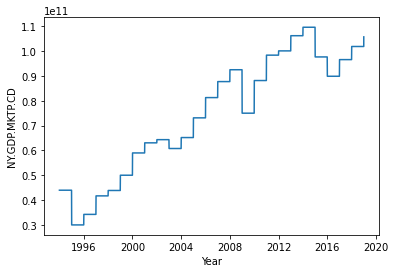

In [ ]:

sns.lineplot(data = dex, x = 'Year', y = 'NY.GDP.MKTP.CD')

In [ ]:
#dex[dex['Class'].isnull() | dex['Class'].isna()].tail(200)
#dex.loc[13306:13606]
N = MEX[MEX['Class'].isnull() | MEX['Class'].isna()]
N.drop_duplicates()

TMG_CIF_USD  ENDA_XDC_USD_RATE    PCPI_IX   TXG_FOB_USD  FIDR_PA  \
Year                                                                            
1994-01-01  1.875143e+08             3.1075  19.004407  1.319065e+08    10.96   
1994-02-01  2.256883e+08             3.1115  19.102151  1.618321e+08    10.08   
1994-03-01  2.190425e+08             3.2841  19.200372  1.663065e+08    10.16   

            FILR_PA  NY.GDP.MKTP.CD  GDP % Increase  Real Interest Rate(%)  \
Year                                                                         
1994-01-01    13.89    4.398444e+10             NaN              -5.114407   
1994-02-01    13.06    4.398444e+10             NaN              -6.042151   
1994-03-01    13.46    4.398444e+10             NaN              -5.740372   

            Foreign Exchange Reserves(%)  M2 Multiplier Growth (%)  \
Year                                                                 
1994-01-01                     60.032598                       NaN   
1994-02-01                     66.278216                 -0.554976   
1994-03-01                     58.475229                  3.099459   

            M2/Reserves  REED 12mth std dev  Domestic Credit to GDP  \
Year                                                                  
1994-01-01     4.301923                 NaN                3.740085   
1994-02-01     3.869932                 NaN                3.714928   
1994-03-01     4.284617                 NaN                3.875741   

            Trade Openness  Class  
Year                               
1994-01-01        0.225126    NaN  
1994-02-01        0.246691    NaN  
1994-03-01        0.271592    NaN

In [ ]:
MEX.drop_duplicates().tail(60)

TMG_CIF_USD  ENDA_XDC_USD_RATE     PCPI_IX   TXG_FOB_USD  \
Year                                                                    
2014-02-01  8.336955e+07            13.2888  115.430865  1.087077e+09   
2014-03-01  8.275236e+07            13.2154  115.747106  1.071379e+09   
2014-04-01  8.988809e+07            13.0681  115.531170  1.134782e+09   
2014-05-01  8.959892e+07            12.9479  115.161718  1.107313e+09   
2014-06-01  8.909753e+07            12.9832  115.361293  1.115415e+09   
2014-07-01  9.057078e+07            12.9734  115.678542  1.086115e+09   
2014-08-01  8.882751e+07            13.1490  116.094040  1.073366e+09   
2014-09-01  8.926376e+07            13.2002  116.606778  1.141536e+09   
2014-10-01  9.284859e+07            13.4768  117.251534  1.189912e+09   
2014-11-01  8.608409e+07            13.5819  118.197166  1.076259e+09   
2014-12-01  7.949861e+07            14.4266  118.776410  1.107993e+09   
2015-01-01  6.881398e+07            14.6757  118.668953  8.577830e+08   
2015-02-01  7.321735e+07            14.9167  118.894112  1.061888e+09   
2015-03-01  7.501469e+07            15.2003  119.378173  1.105566e+09   
2015-04-01  7.596385e+07            15.2228  119.069111  1.099445e+09   
2015-05-01  7.184140e+07            15.2555  118.474514  1.008603e+09   
2015-06-01  7.832439e+07            15.4562  118.673053  1.128908e+09   
2015-07-01  7.476615e+07            15.8881  118.847031  1.058171e+09   
2015-08-01  6.949670e+07            16.4880  119.097760  1.003692e+09   
2015-09-01  6.997256e+07            16.8372  119.543977  1.073793e+09   
2015-10-01  7.262795e+07            16.6020  120.159050  1.098465e+09   
2015-11-01  6.857747e+07            16.6348  120.815059  1.032905e+09   
2015-12-01  6.352547e+07            17.0019  121.307308  1.009187e+09   
2016-01-01  5.020017e+07            17.9780  121.769900  7.995298e+08   
2016-02-01  5.549969e+07            18.4837  122.303099  9.976747e+08   
2016-03-01  5.711455e+07            17.7383  122.483220  1.009290e+09   
2016-04-01  6.192274e+07            17.4924  122.095336  1.011473e+09   
2016-05-01  5.695485e+07            18.0405  121.550898  1.015616e+09   
2016-06-01  5.803579e+07            18.6471  121.684961  1.060579e+09   
2016-07-01  5.488831e+07            18.5699  122.002224  9.579851e+08   
2016-08-01  5.993821e+07            18.4760  122.346079  1.043432e+09   
2016-09-01  5.961364e+07            19.1386  123.093171  1.084940e+09   
2016-10-01  5.702100e+07            18.9480  123.840262  1.044842e+09   
2016-11-01  5.727301e+07            19.9425  124.808426  1.147909e+09   
2016-12-01  5.221383e+07            20.5137  125.383570  1.067865e+09   
2017-01-01  4.646553e+07            21.3732  127.515345  8.769976e+08   
2017-02-01  5.359436e+07            20.3812  128.252206  1.110579e+09   
2017-03-01  6.001937e+07            19.4067  129.039213  1.152139e+09   
2017-04-01  5.485144e+07            18.7584  129.197851  1.058850e+09   
2017-05-01  6.275157e+07            18.7862  129.043299  1.138506e+09   
2017-06-01  6.513931e+07            18.1901  129.367728  1.179701e+09   
2017-07-01  6.087044e+07            17.8513  129.856925  1.033192e+09   
2017-08-01  6.976057e+07            17.8078  130.498603  1.157784e+09   
2017-09-01  6.686608e+07            17.7991  130.906935  1.125315e+09   
2017-10-01  6.713094e+07            18.7247  131.730792  1.184760e+09   
2017-11-01  6.513259e+07            18.9770  133.088869  1.243712e+09   
2017-12-01  6.088948e+07            19.0625  133.875863  1.165558e+09   
2018-01-01  5.964988e+07            19.0025  134.587140  9.852098e+08   
2018-02-01  6.546868e+07            18.6282  135.099864  1.252224e+09   
2018-03-01  6.514557e+07            18.6839  135.536872  1.267691e+09   
2018-04-01  6.807821e+07            18.3464  135.077359  1.237747e+09   
2018-05-01  6.747067e+07            19.4894  134.858344  1.263936e+09   
2018-06-01  6.299055e+07            20.3105  135.379255  1.243720e+09  

In [ ]:
Get_Monthly_GDP('MEX',1999, 2018)

Year  NY.GDP.MKTP.CD  GDP % Increase
0   1999-01-01    5.001941e+10             NaN
1   1999-02-01    5.001941e+10             NaN
2   1999-03-01    5.001941e+10             NaN
3   1999-04-01    5.001941e+10             NaN
4   1999-05-01    5.001941e+10             NaN
..         ...             ...             ...
236 2018-09-01    1.018624e+11        0.456144
237 2018-10-01    1.018624e+11        0.456144
238 2018-11-01    1.018624e+11        0.456144
239 2018-12-01    1.018624e+11        0.456144
240 2019-01-01    1.057392e+11        0.317161

[241 rows x 3 columns]

In [ ]:
Get_Quarterly_GDP('MEX',1999, 2018)

Year  NY.GDP.MKTP.CD
0  1999-01-01    1.500582e+11
1  1999-04-01    1.500582e+11
2  1999-07-01    1.500582e+11
3  1999-10-01    1.500582e+11
4  2000-01-01    1.769767e+11
..        ...             ...
76 2018-01-01    3.055872e+11
77 2018-04-01    3.055872e+11
78 2018-07-01    3.055872e+11
79 2018-10-01    3.055872e+11
80 2019-01-01    3.172176e+11

[81 rows x 2 columns]

### Quarterly Data Call

Calling the quarterly available data &amp; Translating to munthly 

In [ ]:
Get_Monthly_QEDS('MEX',2000, 2008)

Year  DP.DOD.DECN.CR.GG.Z1  DP.DOD.DSTC.CR.GG.Z1
0  2000-01-01                   NaN                   NaN
1  2000-02-01                   NaN                   NaN
2  2000-03-01                   NaN                   NaN
3  2000-04-01                   NaN                   NaN
4  2000-05-01                   NaN                   NaN
..        ...                   ...                   ...
92 2007-09-01                   NaN                   NaN
93 2007-10-01                   NaN                   NaN
94 2007-11-01             18.283104              2.168603
95 2007-12-01             18.283104              2.168603
96 2008-01-01             18.283104              2.168603

[97 rows x 3 columns]

In [ ]:
whole=join_data('MX',1980, 2018).reset_index()

In [ ]:
MEX_Q = Call_Q_IMF('MX', 1980,2020)
print(MEX_Q.shape)
MEX_Q

(14885, 6)


IAP_BP6_USD  LUR_PT  FDI as % of GDP(%)  \
Year                                                   
1980-01-01           NaN     NaN            0.781909   
1980-01-02           NaN     NaN            0.781909   
1980-01-03           NaN     NaN            0.781909   
1980-01-04           NaN     NaN            0.781909   
1980-01-05           NaN     NaN            0.781909   
...                  ...     ...                 ...   
2020-09-27  7.420926e+08     NaN                 NaN   
2020-09-28  7.420926e+08     NaN                 NaN   
2020-09-29  7.420926e+08     NaN                 NaN   
2020-09-30  7.420926e+08     NaN                 NaN   
2020-10-01  8.223549e+08     NaN                 NaN   

            Foreign Exchange Reserves(%)  DP.DOD.DECN.CR.GG.Z1  \
Year                                                             
1980-01-01                     -2.601162                   NaN   
1980-01-02                     -2.601162                   NaN   
1980-01-03                     -2.601162                   NaN   
1980-01-04                     -2.601162                   NaN   
1980-01-05                     -2.601162                   NaN   
...                                  ...                   ...   
2020-09-27                           NaN                   NaN   
2020-09-28                           NaN                   NaN   
2020-09-29                           NaN                   NaN   
2020-09-30                           NaN                   NaN   
2020-10-01                           NaN                   NaN   

            DP.DOD.DSTC.CR.GG.Z1  
Year                              
1980-01-01                   NaN  
1980-01-02                   NaN  
1980-01-03                   NaN  
1980-01-04                   NaN  
1980-01-05                   NaN  
...                          ...  
2020-09-27                   NaN  
2020-09-28                   NaN  
2020-09-29                   NaN  
2020-09-30                   NaN  
2020-10-01                   NaN  

[14885 rows x 6 columns]

### Annual Data top be finished

In [ ]:
Call_WB(iso3='MEX', id='NE.CON.GOVT.ZS',start=1995, finish=2019)

Country  Year  NE.CON.GOVT.ZS
4400     MEX  1995        8.551160
4401     MEX  1996        8.119714
4402     MEX  1997        8.261602
4403     MEX  1998        8.543129
4404     MEX  1999        9.178512
4405     MEX  2000        9.515219
4406     MEX  2001        9.881126
4407     MEX  2002       10.377716
4408     MEX  2003       11.033790
4409     MEX  2004       10.487290
4410     MEX  2005       10.521707
4411     MEX  2006       10.344423
4412     MEX  2007       10.405381
4413     MEX  2008       10.729519
4414     MEX  2009       11.916964
4415     MEX  2010       11.771363
4416     MEX  2011       11.777083
4417     MEX  2012       11.946734
4418     MEX  2013       12.191387
4419     MEX  2014       12.194962
4420     MEX  2015       12.317196
4421     MEX  2016       12.010413
4422     MEX  2017       11.616596
4423     MEX  2018       11.570890
4424     MEX  2019       11.358333

## Joining Data

# Pre processing for RNN

In [16]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
def generate_cyclical_features(df, col_name, period, start_num=0, drop = 'Y'):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/df[period]),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/df[period])    
             }
    if drop == 'Y':
        df = df.assign(**kwargs).drop(columns=[col_name, period])
    elif drop == 'N':
        df = df.assign(**kwargs)
    return df

def cyclical_data(dataset):
    A = dataset.reset_index().copy()
    idx = A.columns[0]
    period = pd.to_datetime(A[idx]).dt.to_period('D')
    A['Yr'] = period.dt.year
    A['leap'] = period.dt.is_leap_year
    A['day/yr'] = np.where(A['leap']==True, 366,365)
    A['day/M'] = period.dt.daysinmonth
    A['M/yr'] = period.dt.daysinmonth
    A['DoM'] = period.dt.day
    A['MoY'] = period.dt.month
    A['DoY'] = period.dt.dayofyear

    A = generate_cyclical_features(A,'DoY','day/yr',1,drop = 'Y')
    A = generate_cyclical_features(A, 'MoY','M/yr',1,drop = 'Y')
    A = generate_cyclical_features(A, 'DoM','day/M',1,drop = 'Y')
    A.drop(columns=['Yr', 'leap'], inplace= True)
    dataset = A.copy()
    dataset.set_index(idx,inplace = True)
    return dataset

def Add_datetimes(dataset, wave = _):
    A = dataset.reset_index().copy()
    idx = A.columns[0]
    period = pd.to_datetime(A[idx]).dt.to_period('D')
    A['Yr'] = period.dt.year
    
    A['DoM'] = period.dt.day
    A['MoY'] = period.dt.month
    
    if wave == 'Y':
        A['leap'] = period.dt.is_leap_year
        A['DoY'] = period.dt.dayofyear
        A['day/yr'] = np.where(A['leap']==True, 366,365)
        A = generate_cyclical_features(A,'DoY','day/yr',1,drop = 'Y')
        A.drop(columns=['leap'], inplace= True)
    
    dataset = A.copy()
    dataset.set_index(idx,inplace = True)
    return dataset

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
    
scaler = get_scaler('standard')

#def reform_dataset():

#def train_test_split(): 

In [ ]:
#pd.get_dummies(MEX, prefix=['Class'], dummy_na=True)

ValueError: Length of 'prefix' (1) did not match the length of the columns being encoded (0).

In [ ]:
#MEX = pd.get_dummies(MEX, prefix=['Class'], dummy_na=True)
MEX = cyclical_data(MEX)
MEX.drop(index=MEX.index[-1], axis=0, inplace=True)
v = MEX.dropna(axis=0, how='any')
v

TMG_CIF_USD  ENDA_XDC_USD_RATE    PCPI_IX   TXG_FOB_USD  FIDR_PA  \
Year                                                                            
1995-01-01  2.107543e+08             5.5133  20.947873  1.913677e+08    26.96   
1995-01-02  2.107543e+08             5.5133  20.947873  1.913677e+08    26.96   
1995-01-03  2.107543e+08             5.5133  20.947873  1.913677e+08    26.96   
1995-01-04  2.107543e+08             5.5133  20.947873  1.913677e+08    26.96   
1995-01-05  2.107543e+08             5.5133  20.947873  1.913677e+08    26.96   
...                  ...                ...        ...           ...      ...   
2009-08-27  5.256243e+07            13.0015  96.094210  6.314438e+08     1.52   
2009-08-28  5.256243e+07            13.0015  96.094210  6.314438e+08     1.52   
2009-08-29  5.256243e+07            13.0015  96.094210  6.314438e+08     1.52   
2009-08-30  5.256243e+07            13.0015  96.094210  6.314438e+08     1.52   
2009-08-31  5.256243e+07            13.0015  96.094210  6.314438e+08     1.52   

            FILR_PA  NY.GDP.MKTP.CD  GDP % Increase  Real Interest Rate(%)  \
Year                                                                         
1995-01-01    53.99    3.000616e+10       -0.085430              33.042127   
1995-01-02    53.99    3.000616e+10       -0.085430              33.042127   
1995-01-03    53.99    3.000616e+10       -0.085430              33.042127   
1995-01-04    53.99    3.000616e+10       -0.085430              33.042127   
1995-01-05    53.99    3.000616e+10       -0.085430              33.042127   
...             ...             ...             ...                    ...   
2009-08-27     5.71    7.500378e+10       -0.050844             -90.384210   
2009-08-28     5.71    7.500378e+10       -0.050844             -90.384210   
2009-08-29     5.71    7.500378e+10       -0.050844             -90.384210   
2009-08-30     5.71    7.500378e+10       -0.050844             -90.384210   
2009-08-31     5.71    7.500378e+10       -0.050844             -90.384210   

            Foreign Exchange Reserves(%)  ...  REED 12mth std dev  \
Year                                      ...                       
1995-01-01                     14.200418  ...           12.498417   
1995-01-02                     14.200418  ...           12.498417   
1995-01-03                     14.200418  ...           12.498417   
1995-01-04                     14.200418  ...           12.498417   
1995-01-05                     14.200418  ...           12.498417   
...                                  ...  ...                 ...   
2009-08-27                    105.721257  ...            6.322751   
2009-08-28                    105.721257  ...            6.322751   
2009-08-29                    105.721257  ...            6.322751   
2009-08-30                    105.721257  ...            6.322751   
2009-08-31                    105.721257  ...            6.322751   

            Domestic Credit to GDP  Trade Openness  Class   sin_DoY   cos_DoY  \
Year                                                                            
1995-01-01                4.507862        0.415441    3.0  0.000000  1.000000   
1995-01-02                4.507862        0.415441    3.0  0.017213  0.999852   
1995-01-03                4.507862        0.415441    3.0  0.034422  0.999407   
1995-01-04                4.507862        0.415441    3.0  0.051620  0.998667   
1995-01-05                4.507862        0.415441    3.0  0.068802  0.997630   
...                            ...             ...    ...       ...       ...   
2009-08-27                4.077324        0.282708    0.0 -0.816538 -0.577292   
2009-08-28                4.077324        0.282708    0.0 -0.826354 -0.563151   
2009-08-29                4.077324        0.282708    0.0 -0.835925 -0.548843   
2009-08-30                4.077324        0.282708    0.0 -0.845249 -0.534373   
2009-08-31                4.077324        0.282708    0.0 -0.854322 -0.519

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


#Set split param
test_ratio = 0.2
val_ratio = test_ratio / (1 - test_ratio)
X, y = v.drop(['Class'], axis=1) , v[['Class']]

#Train & Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
#Train & Validation 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)

In [ ]:
scaler = get_scaler('standard')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch 
from torch import nn
from datetime import datetime
batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        #model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        model_path = 'RNN_Test'
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
    
    
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 7, 30, 8, 28, 54, 489354)

[1/100] Training loss: 0.9575	 Validation loss: 0.0936
[2/100] Training loss: 0.7268	 Validation loss: 0.0532
[3/100] Training loss: 0.6339	 Validation loss: 0.1084
[4/100] Training loss: 0.5595	 Validation loss: 0.0936
[5/100] Training loss: 0.5143	 Validation loss: 0.0997
[6/100] Training loss: 0.4819	 Validation loss: 0.0773
[7/100] Training loss: 0.4539	 Validation loss: 0.1194
[8/100] Training loss: 0.4182	 Validation loss: 0.1025
[9/100] Training loss: 0.4190	 Validation loss: 0.1409
[10/100] Training loss: 0.3933	 Validation loss: 0.0942
[50/100] Training loss: 0.0364	 Validation loss: 0.0539
[100/100] Training loss: 0.0195	 Validation loss: 0.0291


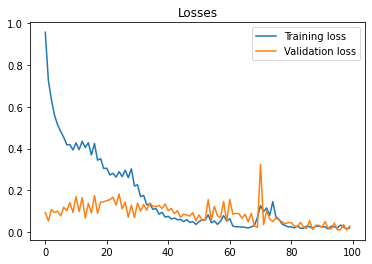

In [ ]:
import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model("rnn", model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [ ]:

def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)

In [ ]:
df_result

value  prediction
Year                                
2006-09-25  4.127617e-09   -0.222379
2006-09-26  4.127617e-09   -0.227436
2006-09-27  4.127617e-09   -0.233498
2006-09-28  4.127617e-09   -0.240389
2006-09-29  4.127617e-09   -0.247881
...                  ...         ...
2009-08-27  4.127617e-09   -0.009160
2009-08-28  4.127617e-09   -0.009718
2009-08-29  4.127617e-09   -0.010325
2009-08-30  4.127617e-09   -0.010952
2009-08-31  4.127617e-09   -0.011578

[1072 rows x 2 columns]

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

result_metrics = calculate_metrics(df_result)


ValueError: If using all scalar values, you must pass an index

In [ ]:
pd.DataFrame(result_metrics, index = [1,2,3])

mae      rmse        r2
1  0.443964  0.977419 -0.291399
2  0.443964  0.977419 -0.291399
3  0.443964  0.977419 -0.291399

# Classification

## Construct Functions 

Functions required for analysis  

In [ ]:
def Multi_Call_IMF(DB,freq,iso2_list, start, finish, Indicator_code):
    countries = "+".join(iso2_list)    
    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    key = f'{DB}/{freq}.{countries}.{Indicator_code}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    url = f'{core}{key}{time}'

    # Get data from the above URL using the requests package
    data = requests.get(url).json()

    # Load data into a pandas dataframe
    #series = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])


    appended_data = []
    for c in range(len(iso2_list)):
        series = pd.DataFrame(data['CompactData']['DataSet']['Series'][c]['Obs'])
        country_idx = (data['CompactData']['DataSet']['Series'][c]['@REF_AREA'])
        series['Country']= country_idx
        series['@OBS_VALUE']=series['@OBS_VALUE'].astype(float)
        appended_data.append(series)

    appended_data = pd.concat(appended_data)
    appended_data

    appended_data = appended_data[['@TIME_PERIOD','Country','@OBS_VALUE']]
    appended_data.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':Indicator_code}, inplace = True)
    
    return appended_data

def multi_crash(iso2, srt, fin, term, frequency):
    #Money Market Rate
    if term == 'MMK': 
        indicator = 'FIMM_PA'
        rate = 'Money Market Rate'
    #Treasury Bill Rate
    elif term == 'TB': 
        indicator = 'FITB_PA'
        rate = 'Treasury Bill Rate'
    # Central Bank Policy Rate
    elif term == 'central':
        indicator = 'FPOLM_PA'    
        rate = 'Central Bank Policy Rate'
    elif term == 'lend':
        indicator = 'FILR_PA'    
        rate = 'Lending Rate'
    elif term == 'deposit':
        indicator = 'FIDR_PA'    
        rate = 'Deposit Rate'        

    dfs = [ Multi_Call_IMF('IFS',frequency,iso2, srt, fin, indicator),
            Multi_Call_IMF('IFS',frequency,iso2, srt, fin, 'ENDA_XDC_USD_RATE')
            ]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Year','Country'],
                                            how='outer'), dfs).fillna(np.NaN)

    US = Call_IMF('IFS',freq=frequency,Country_iso2='US', start=srt, finish=fin, Indicator_code= indicator)
    US.rename(columns = { US.columns[1]  :f'USA - {rate} - {indicator}'}, inplace = True)
    
    Dataset = pd.merge(df_merged, US, left_on=['Year'], right_on=['Year'], how = 'left' ).copy()
    
    #Create Classification

    if frequency == 'M': 
        per = 3
    #Treasury Bill Rate
    elif frequency == 'Q': 
        per = 4
    # Central Bank Policy Rate
    elif frequency == 'A': 
        per = 1
    Dataset['% Diff'] = Dataset.groupby(['Country'])['ENDA_XDC_USD_RATE'].pct_change(periods = per)
    Dataset['Dom_rate'] = (1+(Dataset.iloc[:,[2]]/100))
    Dataset['US_rate'] = (1+(Dataset.iloc[:,[4]]/100))

    Dataset['rate ratio'] =  Dataset['Dom_rate']/Dataset['US_rate'] 
    Dataset['gamma_def1'] = 100 * Dataset['% Diff'] * Dataset['rate ratio']
    Dataset['gamma_def2']=100*Dataset.groupby(['Country'])['ENDA_XDC_USD_RATE'].pct_change(periods = 3)
    Dataset['gamma_def3']=100*Dataset.groupby(['Country'])['ENDA_XDC_USD_RATE'].pct_change(periods = 6)
    Dataset['gamma_def4']=100*Dataset.groupby(['Country'])['ENDA_XDC_USD_RATE'].pct_change(periods = 12)

    cut_labels = ['Green', 'Yellow', 'Orange', 'Red']
    cuts = [-50,5,10,15,1000]
    Dataset['def1_class'] = pd.cut(Dataset['gamma_def1'],bins=cuts,labels=cut_labels)
    Dataset['def2_class'] = pd.cut(Dataset['gamma_def2'],bins=cuts,labels=cut_labels)
    Dataset['def3_class'] = pd.cut(Dataset['gamma_def3'],bins=cuts,labels=cut_labels)
    Dataset['def4_class'] = pd.cut(Dataset['gamma_def4'],bins=cuts,labels=cut_labels)

    ##Classifiy Country
    #countries = wb.get_countries().reset_index()
    #C = countries['id'][countries['iso2Code']==iso2].item()
    #Dataset['Country'] = C
    WB_countries = wb.get_countries().reset_index()
    EM_regions = WB_countries[WB_countries['iso2Code'].isin(iso2)]
    EM_regions = EM_regions[['iso2Code', 'region']]
    EM_regions.rename(columns={'iso2Code':'Country'}, inplace=True)
    Dataset = pd.merge(Dataset,EM_regions,on=['Country'],how = 'left')
    return Dataset

def plot_crash_and_rates(full_data):
    full_data['Date'] = pd.to_datetime(full_data.Year)

    full_data.sort_values(by=['Date','Country'])
    cntry = full_data.Country.unique().tolist()



    fig, ax = plt.subplots(nrows = len(cntry), ncols = 2, figsize=(20,20))

    for i in range(len(cntry)):
        
        data = full_data[full_data.Country ==cntry[i]].copy()
        data.dropna(subset=['gamma_def1'], inplace = True, axis=0)
        #data.dropna(how='any',axis=0)
        data.sort_values(by=['Date','Country'])
        x = data.Date

        ax[i,0].plot(x, data.gamma_def1, color='#FF0101')
        ax[i,0].plot(x, data.gamma_def2, color='#A8328E')
        ax[i,0].plot(x, data.gamma_def3, color='#1501FF')
        ax[i,0].plot(x, data.gamma_def4, color='#58A832')
        
        #Straight lines
        ax[i,0].plot([x.min(), x.max()], [5, 5],color='#ffff63',linestyle = '--' ,  linewidth= 0.5) #5%
        ax[i,0].plot([x.min(), x.max()], [10, 10],color='#ff8d23',linestyle = '--' ,  linewidth= 0.5) #10%
        ax[i,0].plot([x.min(), x.max()], [15, 15],color='#ff00ff',linestyle = '--' , linewidth= 0.5) #15%
        
        ax[i,0].set_title(f'{cntry[i]} - Crash classification time series')
        ax[i,0].set_ylabel('Gamma(%\n Crash Indicator')
        ax[i,0].set_xlabel('Time (Month end time increments) ')
        ax[i,0].legend([f'Indicator inclusive of short rate change', 'FX% Change(3mth)', 'FX% Change(6mth)', 'FX% Change(12mth)'], loc = 'upper center')
        #ax[i,0].fill_between(x,y1,  color='#02d102', alpha = 0.3)
        #ax[i,0].fill_between(x,y1, where=(5 < data.gamma), color='#ffff63', alpha = 0.3)
        #ax[i,0].fill_between(x,y1, where=(10 < data.gamma), color='#ff8d23', alpha = 0.3)
        #ax[i,0].fill_between(x,y1, where=(15 < data.gamma), color='#ff00ff', alpha = 0.3)
        #custom_lines = [Line2D([0],[0],color='#02d102', alpha = 0.3),
        #                Line2D([0], [0], color='#ffff63', alpha = 0.3),
        #                Line2D([0],[0],color='#ff8d23', alpha = 0.3),
        #                Line2D([0], [0], color='#ff00ff', alpha = 0.3)]
        #ax[i,0].legend(custom_lines,['<5%', '5%<gamma', '10%<gamma','15%<gamma'])

        ax[i,1].plot(x, data.iloc[:,2]) #Domestice Short term rate
        ax[i,1].plot(x, data.iloc[:,4]) #US Short term rate
        ax[i,1].set_title(f'US vs {cntry[i]} Short Term Policy Rates')
        ax[i,1].set_ylabel('Policy Rate (%)')
        ax[i,1].set_xlabel('Time')
        ax[i,1].legend([f'{cntry[i]} M-Mkt Rate', 'US M-Mkt Rate'], loc = 'upper center')
        ax0 = ax[i,1].twinx()
        ax0.plot(x, data.iloc[:,3],color='#ff0000',linestyle = '--' ) #FX Rate 
        ax0.set_ylabel(f'{cntry[i]} Domestic Currency per 1 US Dollar ')
        ax0.legend(['FX Rate to USD'], loc = 'upper right')
    fig.tight_layout()

def Categorise_data(Dataframe):
    Dataframe = Dataframe.dropna(subset=['gamma_def1'], axis=0)

    Dataframe = pd.melt(Dataframe[['Country','def1_class','def2_class','def3_class','def4_class']],id_vars=['Country'],
                                                                                     value_vars= ['def1_class','def2_class','def3_class','def4_class'],
                                                                                     var_name = 'class_code',
                                                                                     value_name='class')
    Dataframe = Dataframe.groupby(['Country', 'class_code','class']).agg(Count=('class', 'count')).reset_index()
    Dataframe.sort_values(by=[ 'Country', 'class_code','class'])
    
    return Dataframe

def Categorise_curr_data(Dataframe):
    Dataframe = Dataframe.dropna(subset=['% Diff'], axis=0)

    Dataframe = pd.melt(Dataframe[['Country','Class']],id_vars=['Country'],
                                                    value_vars= ['Class'],
                                                    var_name = 'class_code',
                                                    value_name='class')
    Dataframe = Dataframe.groupby(['Country', 'class_code','class']).agg(Count=('class', 'count')).reset_index()
    Dataframe.sort_values(by=[ 'Country', 'class_code','class'])
    
    return Dataframe

def catrgorical_bar_plot(Dataframe):
    cat_data = Categorise_data(Dataframe)
    cat_data = cat_data[['Country', 'class_code','class','Count']].copy()
    fig = px.bar(cat_data, x="class", y="Count",
             color='class_code',
             color_discrete_sequence = ['#FF0101','#A8328E','#1501FF','#58A832'],
             barmode='group',
             height=600,
              
             facet_row="Country",
             category_orders={"class":['Green','Yellow','Orange', 'Red']})

    fig.show()

def catrgorical_curr_bar_plot(Dataframe):
    cat_data = Categorise_curr_data(Dataframe)
    cat_data = cat_data[['Country', 'class','Count']].copy()
    fig = px.bar(cat_data, x="class", y="Count",
             color='class',
             color_discrete_sequence = ['#02d102','#ffff63','#ff8d23','#ff00ff'],
             barmode='group',
             height=450, 
             width = 800,
             facet_row="Country",
             category_orders={"class":['normal behaviour', 'Low', 'Medium', 'High']})

    fig.show()
def q25(x):
    return x.quantile(0.25)
def q60(x):
    return x.quantile(0.60)
def q75(x):
    return x.quantile(0.75)
def q80(x):
    return x.quantile(0.80)
def q95(x):
    return x.quantile(0.95)
    
def country_threshold_table(full_data):
    data = full_data.dropna(subset=['gamma_def2'],axis=0).groupby(['region', 'Country']).agg(Start_yr=('Year', np.min),
                                                                                last_yr=('Year', np.max),
                                                                                Min_move=('gamma_def2', np.min),
                                                                                Max_move=('gamma_def2', np.max),
                                                                                Mean_move =('gamma_def2',np.mean ),
                                                                                Q_25 =('gamma_def2', q25 ),
                                                                                Q_60 =('gamma_def2', q60 ),
                                                                                Q_75 =('gamma_def2', q75 ),
                                                                                Q_80 =('gamma_def2', q80 ),
                                                                                Q_95 =('gamma_def2', q95 ),
                                                                                SD =('gamma_def2',np.std )).reset_index()
    data.sort_values(by=['region', 'Country'])
    return data
def region_threshold_table(full_data):
    data = full_data.dropna(subset=['gamma_def2'],axis=0).groupby(['region']).agg(Start_yr=('Year', np.min),
                                                                                last_yr=('Year', np.max),
                                                                                Min_move=('gamma_def2', np.min),
                                                                                Max_move=('gamma_def2', np.max),
                                                                                Mean_move =('gamma_def2',np.mean ),
                                                                                Q_25 =('gamma_def2', q25 ),
                                                                                Q_60 =('gamma_def2', q60 ),
                                                                                Q_75 =('gamma_def2', q75 ),
                                                                                Q_80 =('gamma_def2', q80 ),
                                                                                Q_95 =('gamma_def2', q95 ),
                                                                                SD =('gamma_def2',np.std )).reset_index()
    data.sort_values(by=['region'])
    return data

def region_threshold_table2(full_data):
    data = full_data.dropna(subset=['% Diff'],axis=0).groupby(['region']).agg(Start_yr=('Year', np.min),
                                                                                last_yr=('Year', np.max),
                                                                                Min_move=('% Diff', np.min),
                                                                                Max_move=('% Diff', np.max),
                                                                                Mean_move =('% Diff',np.mean ),
                                                                                Q_25 =('% Diff', q25 ),
                                                                                Q_60 =('% Diff', q60 ),
                                                                                Q_75 =('% Diff', q75 ),
                                                                                Q_80 =('% Diff', q80 ),
                                                                                Q_95 =('% Diff', q95 ),
                                                                                SD =('% Diff',np.std )).reset_index()
    data.sort_values(by=['region'])
    return data

def multi_curr_crash(iso2, srt, fin):
 
    Dataset = Multi_Call_IMF('IFS','M',iso2, srt, fin, 'ENDA_XDC_USD_RATE')
    
    #Create Classification

    Dataset['% Diff'] = Dataset.groupby(['Country'])['ENDA_XDC_USD_RATE'].pct_change(periods = 3)
    Dataset['% Diff'] = 100*Dataset['% Diff']
    

    WB_countries = wb.get_countries().reset_index()
    EM_regions = WB_countries[WB_countries['iso2Code'].isin(iso2)]
    EM_regions = EM_regions[['iso2Code', 'region']]
    EM_regions.rename(columns={'iso2Code':'Country'}, inplace=True)
    Dataset = pd.merge(Dataset,EM_regions,on=['Country'],how = 'left')
    

    regions = pd.DataFrame({'region':['East Asia & Pacific', 'Europe & Central Asia','Latin America & Caribbean ', 'South Asia','Sub-Saharan Africa '],
                        'Level_1':[5,10,7.5,5,5],
                        'Level_2':[10,15,12.5,10,10],
                        'Level_3':[15,20,17.5,15,15]
                        })

    desc_reg = region_threshold_table2(Dataset)

    regions = pd.merge(regions,desc_reg[['region', 'Min_move','Max_move']],on=['region'],how = 'left')
    Dataset = pd.merge(Dataset,regions,on=['region'],how = 'left')

    cut_labels = ['normal behaviour', 'Low', 'Medium', 'High']
    
    for i in range(regions.shape[0]):

        cuts = [regions.loc[i,'Min_move'],regions.loc[i,'Level_1'],regions.loc[i,'Level_2'],regions.loc[i,'Level_3'],regions.loc[i,'Max_move']]
        r = regions.loc[i,'region']
        if 'Class' not in Dataset.columns:
            Dataset['Class'] = np.NaN
        Dataset['Class'][Dataset['region']== r] = pd.cut(Dataset['% Diff'],bins=cuts,labels=cut_labels)
    
    return Dataset


## Plotting Various Classifications methods 

Indicatior definition 1 takes int account the monry market, 'MMK', rate (thic can be altered to the Treasury Bill rate 'treasury', Central policy rate 'central', or the lending rate 'lending' ). 
Definition 1,2 & 3 account solely on the change in the currency over a 3, 6 and 12 month rolling period, respectively. 

## Latin America Case study

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


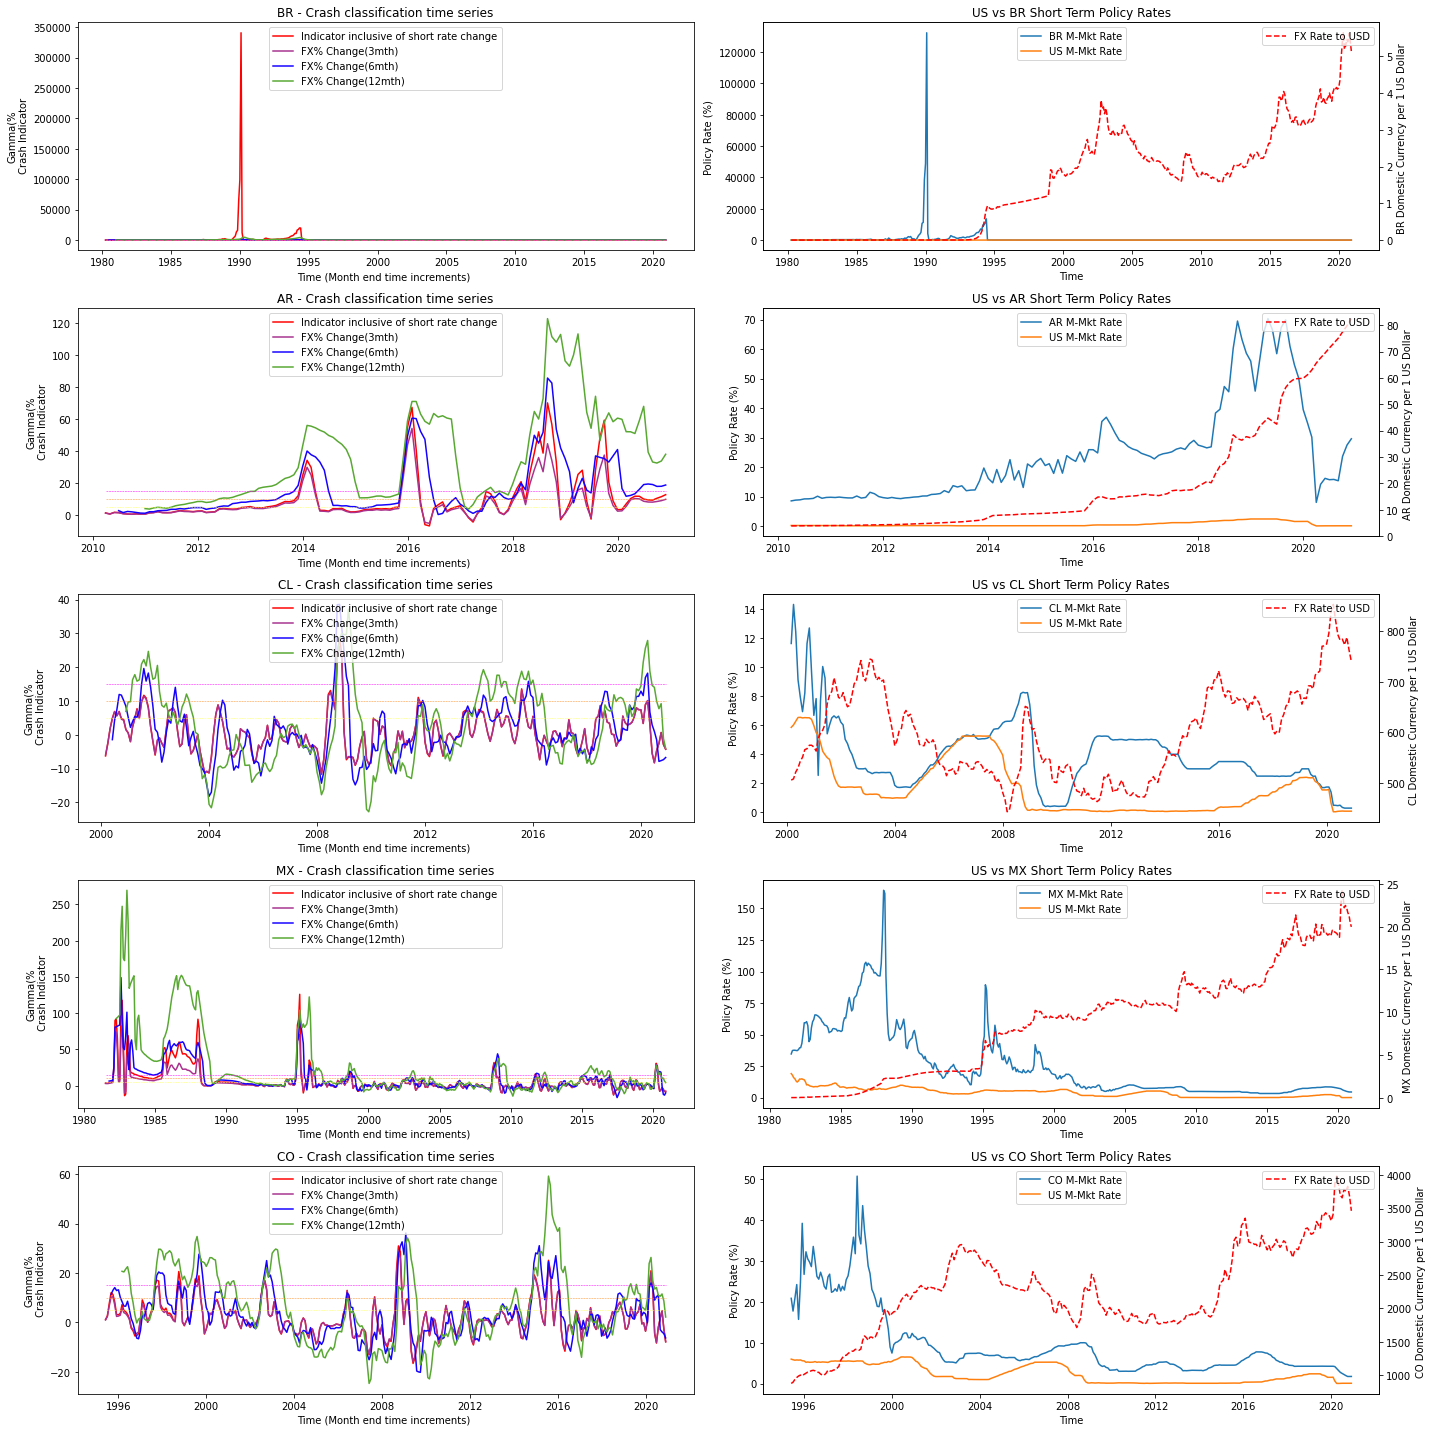

In [ ]:
test_mmk = ['AR','BR','CL','MX','CO','CZ', 'PL','RO','RU','ZA','IN','KR','MY','PH','TH'] # No data for :'EG','HU','TR'
#TR, IL, EG, HU- Central

EM_MMK_1980_2020 = multi_crash(test_mmk,'1980', '2020', term='MMK', frequency ='M')
LATM =EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('Latin America & Caribbean')]
plot_crash_and_rates(LATM)

In [ ]:
LATM

Year Country    FIMM_PA  ENDA_XDC_USD_RATE  \
0     1980-01      BR  41.747762       1.888667e-11   
1     1980-02      BR  34.017291       1.941419e-11   
2     1980-03      BR  52.337812       2.012997e-11   
3     1980-04      BR  26.080163       2.091239e-11   
4     1980-05      BR  27.272519       2.154680e-11   
...       ...     ...        ...                ...   
7058  1994-10      CO        NaN       8.395417e+02   
7059  1994-11      CO        NaN       8.300250e+02   
7060  1994-12      CO        NaN       8.293436e+02   
7061  1995-01      CO        NaN       8.466729e+02   
7062  1995-02      CO        NaN       8.505701e+02   

      USA - Money Market Rate - FIMM_PA    % Diff  Dom_rate  US_rate  \
0                                 13.82       NaN  1.417478   1.1382   
1                                 14.13       NaN  1.340173   1.1413   
2                                 17.19       NaN  1.523378   1.1719   
3                                 17.61  0.107257  1.260802   1.1761   
4                                 10.98  0.109848  1.272725   1.1098   
...                                 ...       ...       ...      ...   
7058                               4.76  0.024931       NaN   1.0476   
7059                               5.29  0.018657       NaN   1.0529   
7060                               5.45 -0.000867       NaN   1.0545   
7061                               5.53  0.008494       NaN   1.0553   
7062                               5.92  0.024752       NaN   1.0592   

      rate ratio  gamma_def1  gamma_def2  gamma_def3  gamma_def4 def1_class  \
0       1.245368         NaN         NaN         NaN         NaN        NaN   
1       1.174251         NaN         NaN         NaN         NaN        NaN   
2       1.299922         NaN         NaN         NaN         NaN        NaN   
3       1.072019   11.498113   10.725660         NaN         NaN     Orange   
4       1.146806   12.597431   10.984798         NaN         NaN     Orange   
...          ...         ...         ...         ...         ...        ...   
7058         NaN         NaN    2.493058    0.887559   -6.146651        NaN   
7059         NaN         NaN    1.865654   -1.350246   -7.712549        NaN   
7060         NaN         NaN   -0.086692   -0.184983   -9.150380        NaN   
7061         NaN         NaN    0.849418    3.363653   -8.090329        NaN   
7062         NaN         NaN    2.475233    4.387066   -8.514290        NaN   

     def2_class def3_class def4_class                      region       Date  
0           NaN        NaN        NaN  Latin America & Caribbean  1980-01-01  
1           NaN        NaN        NaN  Latin America & Caribbean  1980-02-01  
2           NaN        NaN        NaN  Latin America & Caribbean  1980-03-01  
3        Orange        NaN        NaN  Latin America & Caribbean  1980-04-01  
4        Orange        NaN        NaN  Latin America & Caribbean  1980-05-01  
...         ...        ...        ...                         ...        ...  
7058      Green      Green      Green  Latin America & Caribbean  1994-10-01  
7059      Green      Green      Green  Latin America & Caribbean  1994-11-01  
7060      Green      Green      Green  Latin America & Caribbean  1994-12-01  
7061      Green      Green      Green  Latin America & Caribbean  1995-01-01  
7062      Green      Green      Green  Latin America & Caribbean  1995-02-01  

[2460 rows x 19 columns]

In [ ]:
Categorise_data(LATM)

Country  class_code   class  Count
0       AR  def1_class   Green     72
1       AR  def1_class  Orange     13
2       AR  def1_class     Red     22
3       AR  def1_class  Yellow     22
4       AR  def2_class   Green     78
..     ...         ...     ...    ...
75      MX  def3_class  Yellow     66
76      MX  def4_class   Green    203
77      MX  def4_class  Orange     42
78      MX  def4_class     Red    155
79      MX  def4_class  Yellow     65

[80 rows x 4 columns]

Representation of how many periods are included in each period: 

green =<  5% change 

yellow = 5-10% Change

Orange = 10-15% Change

Red = 15+% Change

In [ ]:
catrgorical_bar_plot(LATM)

### Focus on 1997 Mexico crash

ConversionError: Failed to convert value(s) to axis units: array([NaT, NaT], dtype=object)

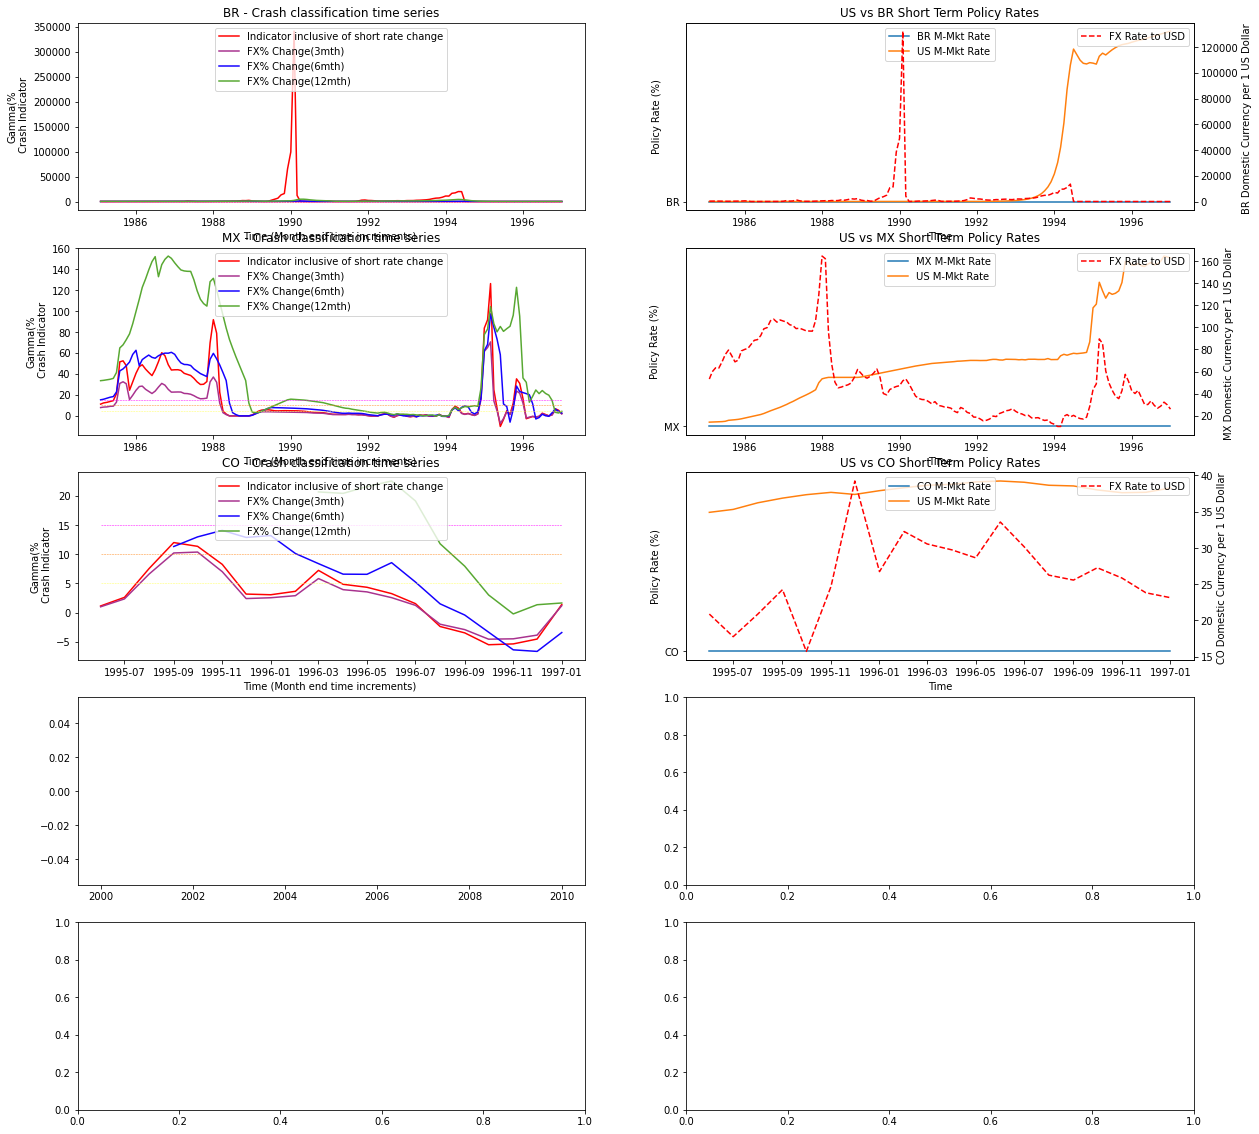

In [ ]:
Teq = multi_crash(test_mmk,1980, 2020, term='MMK', frequency ='M')
Teq =Teq[Teq['region'].str.contains('Latin America & Caribbean')]

start_date = pd.to_datetime(1985, format = '%Y')
end_date = pd.to_datetime(1997, format = '%Y')

#Change to quarter start
Teq['Year'] = pd.to_datetime(Teq['Year'])
#Teq.set_index(['Year'],inplace=True)
Teq = Teq[(Teq['Year'] > start_date) & (Teq['Year'] <= end_date)].copy()

plot_crash_and_rates(Teq.reset_index())
C_Teq = Categorise_data(Teq)


In [ ]:

fig = px.bar(C_Teq, x="class", y="Count",
             color='class_code',
             color_discrete_sequence = ['#FF0101','#A8328E','#1501FF','#58A832'],
             barmode='group',
             height=600, 
             facet_row="Country",
             category_orders={"class":['Green','Yellow','Orange', 'Red']})

fig.show()

## Distribution analysis 

In [ ]:
EM_CUT = EM_MMK_1980_2020.copy()

In [ ]:
country_threshold_table(EM_CUT)

region Country Start_yr  last_yr    Min_move  \
0          East Asia & Pacific      KR  1980-04  2020-12  -18.445629   
1          East Asia & Pacific      MY  1980-04  2020-12  -15.525249   
2          East Asia & Pacific      PH  1980-04  2020-12  -10.742440   
3          East Asia & Pacific      TH  1980-01  2020-12  -34.692070   
4        Europe & Central Asia      CZ  1993-04  2020-12  -12.574690   
5        Europe & Central Asia      PL  1980-01  2020-12  -99.887502   
6        Europe & Central Asia      RO  1980-01  2020-12  -99.956534   
7        Europe & Central Asia      RU  1992-06  2020-12  -99.822139   
8   Latin America & Caribbean       AR  1980-01  2020-12 -100.000000   
9   Latin America & Caribbean       BR  1980-04  2020-12  -17.688582   
10  Latin America & Caribbean       CL  1980-01  2020-12  -95.052439   
11  Latin America & Caribbean       CO  1980-01  2020-12  -98.847824   
12  Latin America & Caribbean       MX  1980-01  2020-12  -99.893185   
13                  South Asia      IN  1980-04  2020-12  -42.723578   
14         Sub-Saharan Africa       ZA  1980-04  2020-12  -24.365240   

       Max_move  Mean_move      Q_25       Q_60       Q_75       Q_80  \
0     85.149428   0.598578 -1.715404   0.846461   2.048426   2.439807   
1     34.089735   0.463036 -1.367828   0.128440   1.354437   2.135757   
2     28.567348   1.268269 -1.167755   1.207768   2.192445   2.941166   
3     43.896243   0.149122 -1.612693   0.131761   1.085381   1.587833   
4     24.517426  -0.072588 -3.784848   0.716135   3.214034   4.120550   
5    382.172313   5.237907 -1.890445   3.027068   6.620209   8.139192   
6    230.998048   5.621275 -1.445486   3.274908   6.537530   7.649248   
7    156.144330   5.028878 -1.919971   1.747597   4.790199   6.358175   
8   1268.436883  22.579764  0.000000   4.212933  14.505463  22.817475   
9    307.182201  22.709883 -0.679749  11.175331  29.946709  35.694178   
10    46.536495   1.457202 -1.240876   2.471653   4.471096   5.357549   
11    28.407596   2.271336 -0.877608   4.263840   6.188365   6.439469   
12    82.700566   4.179487 -0.967642   2.644367   5.891543   7.883790   
13    28.289111   1.220105 -0.493771   1.327022   2.545459   3.217299   
14    34.254842   2.130673 -2.236967   2.986341   5.298084   7.221274   

          Q_95         SD  
0     5.927807   6.866885  
1     6.516846   4.090640  
2     9.248802   4.954957  
3     6.182062   5.551256  
4    10.207226   5.745134  
5    21.387879  28.773645  
6    32.030594  23.668896  
7    36.049280  23.822484  
8    91.336265  87.309336  
9   111.376596  43.177629  
10   10.690242   9.902499  
11   12.505870   9.813091  
12   27.063347  14.337659  
13    8.264741   5.332807  
14   16.986954   7.950282

In [ ]:
region_threshold_table(EM_CUT)

region Start_yr  last_yr    Min_move     Max_move  \
0         East Asia & Pacific  1980-01  2020-12  -34.692070    85.149428   
1       Europe & Central Asia  1980-01  2020-12  -99.956534   382.172313   
2  Latin America & Caribbean   1980-01  2020-12 -100.000000  1268.436883   
3                  South Asia  1980-04  2020-12  -42.723578    28.289111   
4         Sub-Saharan Africa   1980-04  2020-12  -24.365240    34.254842   

   Mean_move      Q_25      Q_60      Q_75      Q_80       Q_95         SD  
0   0.619751 -1.501428  0.497968  1.739553  2.305180   6.832330   5.471286  
1   4.229067 -2.210985  2.402196  5.420050  6.975812  23.442858  23.199693  
2  10.639534 -0.361032  3.898208  7.210378  9.899407  54.134297  45.509352  
3   1.220105 -0.493771  1.327022  2.545459  3.217299   8.264741   5.332807  
4   2.130673 -2.236967  2.986341  5.298084  7.221274  16.986954   7.950282

In [ ]:
reg = region_threshold_table(EM_CUT[(EM_CUT['Country']!='BR')&(EM_CUT['Country']!='AR')&(EM_CUT['Country']!='RU')])
reg

region Start_yr  last_yr   Min_move    Max_move  \
0         East Asia & Pacific  1980-01  2020-12 -34.692070   85.149428   
1       Europe & Central Asia  1980-01  2020-12 -99.956534  382.172313   
2  Latin America & Caribbean   1980-01  2020-12 -99.893185   82.700566   
3                  South Asia  1980-04  2020-12 -42.723578   28.289111   
4         Sub-Saharan Africa   1980-04  2020-12 -24.365240   34.254842   

   Mean_move      Q_25      Q_60      Q_75      Q_80       Q_95         SD  
0   0.619751 -1.501428  0.497968  1.739553  2.305180   6.832330   5.471286  
1   4.032012 -2.351206  2.564559  5.598113  7.077371  21.574065  23.048681  
2   2.636008 -0.974748  3.367862  5.613427  6.430342  15.590093  11.594348  
3   1.220105 -0.493771  1.327022  2.545459  3.217299   8.264741   5.332807  
4   2.130673 -2.236967  2.986341  5.298084  7.221274  16.986954   7.950282

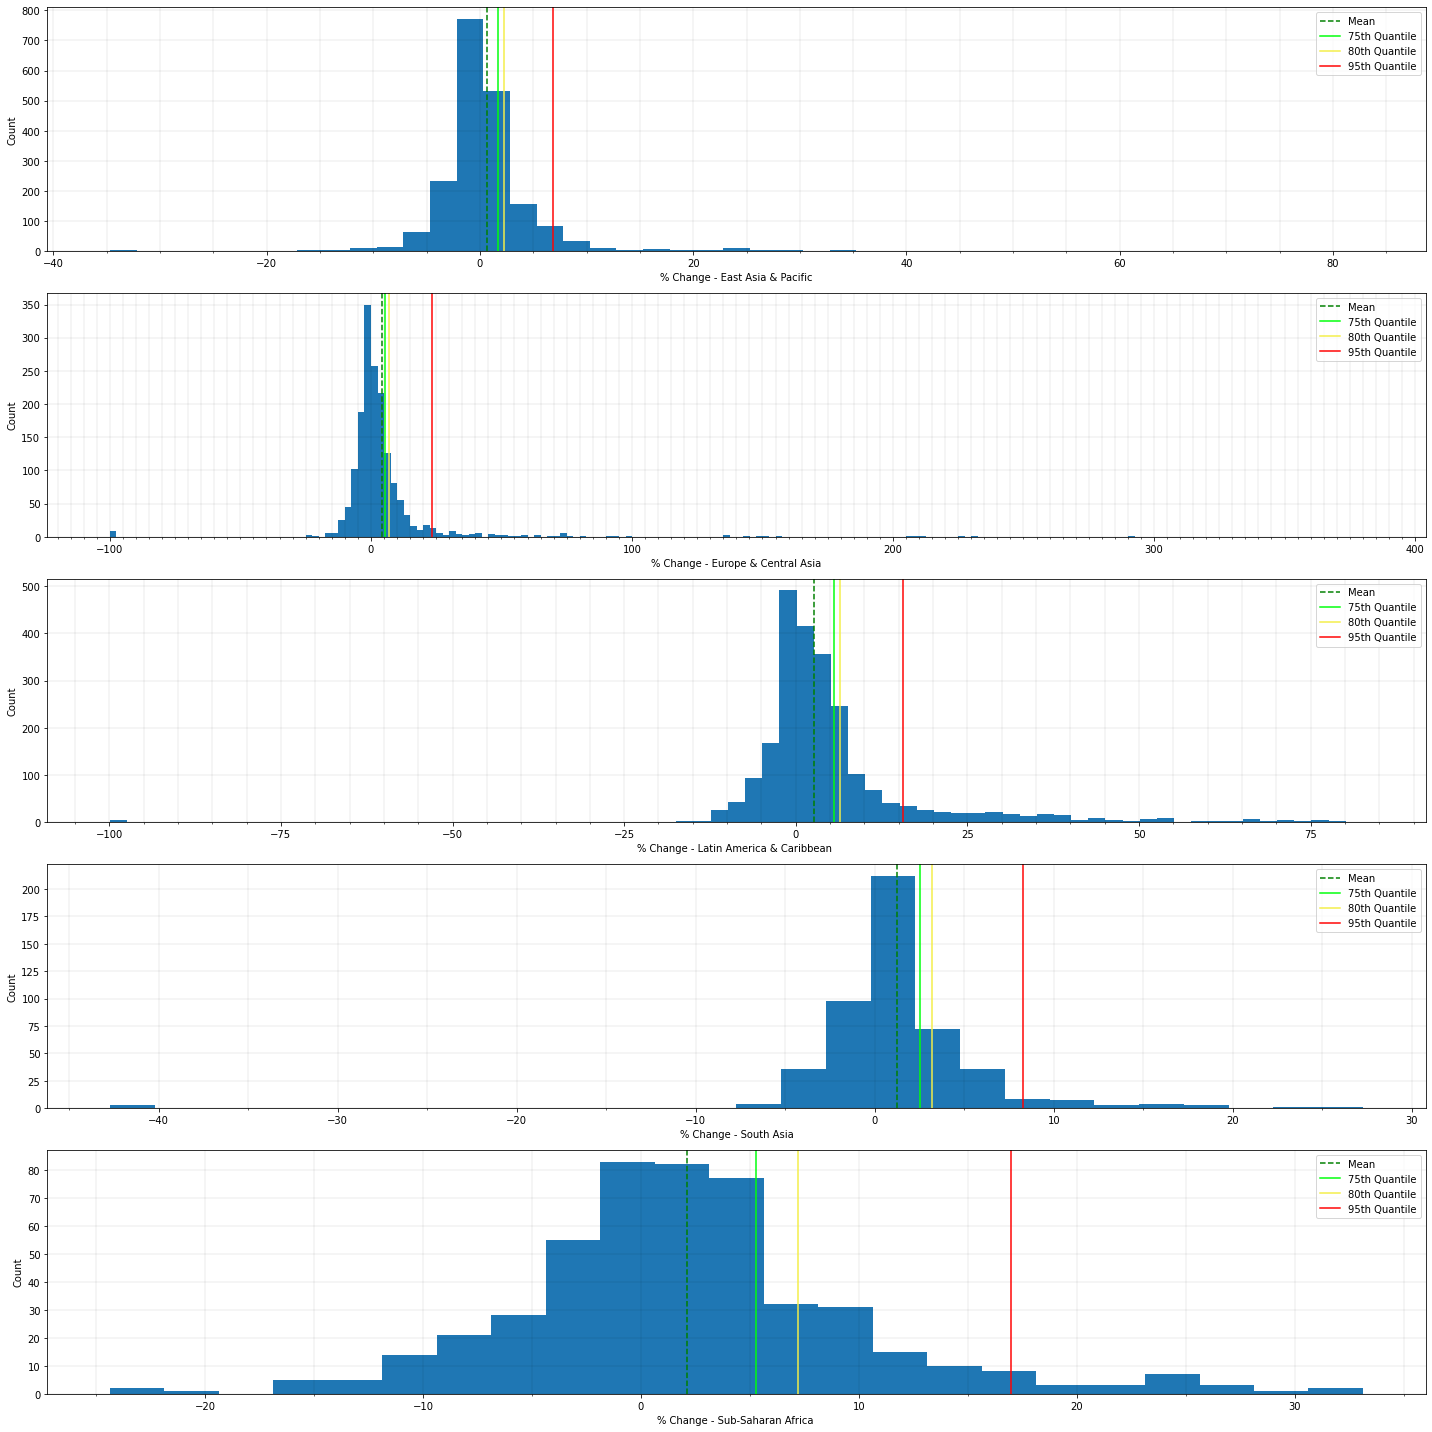

In [ ]:
from matplotlib.ticker import MultipleLocator

regions = ['East Asia & Pacific', 'Europe & Central Asia','Latin America & Caribbean ', 'South Asia','Sub-Saharan Africa ']
fig, ax = plt.subplots(nrows = len(regions), ncols = 1, figsize=(20,20))
for i in range(len(regions)):

    s = reg.loc[i,'Min_move']
    f = reg.loc[i,'Max_move']
    r = reg.loc[i,'region']
    m = reg.loc[i,'Mean_move']
    q = reg.loc[i,'Q_75']
    q95 = reg.loc[i,'Q_95']
    q80 = reg.loc[i,'Q_80']
    #print(s,f)
    bin_values = np.arange(start=s,stop=f,step=2.5)
    #print(bin_values)

    EAP = EM_CUT[EM_CUT['region'] == regions[i]]
    y = EAP['gamma_def2'].to_list() 
    ax[i].hist(y, bins=bin_values  )
    ax[i].axvline(x = m, color = 'g',label = 'Mean', linestyle = '--')
    ax[i].axvline(x = q, color = '#00FF0A' ,label = '75th Quantile')
    ax[i].axvline(x = q80, color = '#F4EE49',label = '80th Quantile')
    ax[i].axvline(x = q95, color ='#FF0303' ,label = '95th Quantile')
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel(f'% Change - {r}')
    ax[i].legend( loc = 'upper right')
    ax[i].grid(b=True, which='major', color='black', linewidth=0.075)
    ax[i].grid(b=True, which='minor', color='black', linewidth=0.075)
    ax[i].xaxis.set_minor_locator(MultipleLocator(5))

    fig.tight_layout()

In [ ]:
cut_labels = ['Green', 'Yellow', 'Orange', 'Red']
    cuts = [-50,5,10,15,1000]
    Dataset['quantiles'] = pd.cut(Dataset['gamma'],
                              bins=cuts,
                              labels=cut_labels)

In [ ]:
regions = pd.DataFrame({'region':['East Asia & Pacific', 'Europe & Central Asia','Latin America & Caribbean ', 'South Asia','Sub-Saharan Africa '],
            'Level_1':[5,10,7.5,5,5],
            'Level_2':[10,15,12.5,10,10],
            'Level_3':[15,20,17.5,15,15]
            })

In [ ]:
regions.loc[0,'Level_1']

5.0

In [ ]:
regions


region  Level_1  Level_2  Level_3
0         East Asia & Pacific      5.0     10.0     15.0
1       Europe & Central Asia     10.0     15.0     20.0
2  Latin America & Caribbean       7.5     12.5     17.5
3                  South Asia      5.0     10.0     15.0
4         Sub-Saharan Africa       5.0     10.0     15.0

## Currency Crash with FX Definition 

In [ ]:
iso_list = ['BR','CL','MX','CO','CZ', 'PL','RO','RU','ZA','IN','KR','MY','PH','TH','EG','HU','TR'] # No data for :'AR',#TR, IL, EG, HU- Central
multi_curr_crash(iso_list,'1980', '2020')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:272: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Year Country  ENDA_XDC_USD_RATE    % Diff  \
0     1980-01      MY           2.180800       NaN   
1     1980-02      MY           2.178700       NaN   
2     1980-03      MY           2.222800       NaN   
3     1980-04      MY           2.285500  4.800990   
4     1980-05      MY           2.187700  0.413090   
...       ...     ...                ...       ...   
8037  2020-08      CO        3788.098947 -1.947618   
8038  2020-09      CO        3757.050500  1.590687   
8039  2020-10      CO        3833.059524  4.689644   
8040  2020-11      CO        3687.764118 -2.648686   
8041  2020-12      CO        3465.769375 -7.752920   

                          region  Level_1  Level_2  Level_3   Min_move  \
0            East Asia & Pacific      5.0     10.0     15.0 -26.638171   
1            East Asia & Pacific      5.0     10.0     15.0 -26.638171   
2            East Asia & Pacific      5.0     10.0     15.0 -26.638171   
3            East Asia & Pacific      5.0     10.0     15.0 -26.638171   
4            East Asia & Pacific      5.0     10.0     15.0 -26.638171   
...                          ...      ...      ...      ...        ...   
8037  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
8038  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
8039  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
8040  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
8041  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   

        Max_move             Class  
0      85.149428               NaN  
1      85.149428               NaN  
2      85.149428               NaN  
3      85.149428  normal behaviour  
4      85.149428  normal behaviour  
...          ...               ...  
8037  307.182201  normal behaviour  
8038  307.182201  normal behaviour  
8039  307.182201  normal behaviour  
8040  307.182201  normal behaviour  
8041  307.182201  normal behaviour  

[8042 rows x 11 columns]

In [ ]:
def plot_curr_crash(full_data):
    full_data['Date'] = pd.to_datetime(full_data.Year)

    full_data.sort_values(by=['Date','Country'])
    cntry = full_data.Country.unique().tolist()

    regions = pd.DataFrame({'region':['East Asia & Pacific', 'Europe & Central Asia','Latin America & Caribbean ', 'South Asia','Sub-Saharan Africa '],
                        'Level_1':[5,10,7.5,5,5],
                        'Level_2':[10,15,12.5,10,10],
                        'Level_3':[15,20,17.5,15,15]
                        })

    fig, ax = plt.subplots(nrows = len(cntry), ncols = 2, figsize=(20,20))

    for i in range(len(cntry)):
        
        data = full_data[full_data.Country ==cntry[i]].copy()
        #data.dropna(subset=['% Diff'], inplace = True, axis=0)
        #data.dropna(how='any',axis=0)
        data.sort_values(by=['Date','Country'])
        x = data.Date
        y = data['% Diff']
        reg_i = regions[regions['region']== data.iloc[1,4]]
        

        ax[i,0].plot(x,y)
        l1 = reg_i.Level_1.item()
        l2 = reg_i.Level_2.item()
        l3 = reg_i.Level_3.item()
        #Straight lines
        ax[i,0].plot([x.min(), x.max()], [l1,l1],color='#ffff63',linestyle = '--' ,  linewidth= 0.5) #low
        ax[i,0].plot([x.min(), x.max()], [l2,l2],color='#ff8d23',linestyle = '--' ,  linewidth= 0.5) #med
        ax[i,0].plot([x.min(), x.max()], [l3,l3],color='#ff00ff',linestyle = '--' , linewidth= 0.5) #high
        
        ax[i,0].set_title(f'{cntry[i]} - Crash classification time series')
        ax[i,0].set_ylabel('Crash Indicator - 3mth FX Rate Change (%)')
        ax[i,0].set_xlabel('Time (Month end time increments) ')
        ax[i,0].legend(['FX% Change(3mth)', f'Low - {l1}', f'Med Band - {l2}',f'High band- {l3}'], loc = 'upper center')
        ax[i,0].fill_between(x,y,  color='#02d102', alpha = 0.3)
        ax[i,0].fill_between(x,y, where=(l1 < y), color='#ffff63')
        ax[i,0].fill_between(x,y, where=(l2 < y), color='#ff8d23')
        ax[i,0].fill_between(x,y, where=(l3 < y), color='#ff00ff')

        ax[i,1].plot(x, data.ENDA_XDC_USD_RATE) #FX Rate      
        ax[i,1].set_title(f'US vs {cntry[i]} FX Month average')
        ax[i,1].set_ylabel('Month average FX Rate (%)')
        ax[i,1].set_xlabel('Time')
        ax[i,1].legend([f'{cntry[i]} Curr vs US FX Rate'], loc = 'upper center')
        
    fig.tight_layout()
    

In [ ]:
iso_list = ['BR','CL','MX','CO','CZ', 'PL','RO','RU','ZA','IN','KR','MY','PH','TH','EG','HU','TR']
Full = multi_curr_crash(iso_list,'1980', '2020')
APAC = Full[(Full['region']=='East Asia & Pacific')| (Full['region']=='South Asia')].copy()
EMEA = Full[(Full['region']=='Europe & Central Asia')| (Full['region']=='Sub-Saharan Africa ')].copy()
LATM = Full[Full['region']=='Latin America & Caribbean '].copy()
S_ASIA = Full[Full['region']=='South Asia'].copy()
#SSAF = Full[Full['region']=='Sub-Saharan Africa '].copy()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
LATM

Year Country  ENDA_XDC_USD_RATE    % Diff  \
5090  1980-01      MX           0.022811       NaN   
5091  1980-02      MX           0.022817       NaN   
5092  1980-03      MX           0.022848       NaN   
5093  1980-04      MX           0.022825  0.061812   
5094  1980-05      MX           0.022836  0.085463   
...       ...     ...                ...       ...   
8037  2020-08      CO        3788.098947 -1.947618   
8038  2020-09      CO        3757.050500  1.590687   
8039  2020-10      CO        3833.059524  4.689644   
8040  2020-11      CO        3687.764118 -2.648686   
8041  2020-12      CO        3465.769375 -7.752920   

                          region  Level_1  Level_2  Level_3   Min_move  \
5090  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
5091  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
5092  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
5093  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
5094  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
...                          ...      ...      ...      ...        ...   
8037  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
8038  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
8039  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
8040  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
8041  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   

        Max_move             Class  
5090  307.182201               NaN  
5091  307.182201               NaN  
5092  307.182201               NaN  
5093  307.182201  normal behaviour  
5094  307.182201  normal behaviour  
...          ...               ...  
8037  307.182201  normal behaviour  
8038  307.182201  normal behaviour  
8039  307.182201  normal behaviour  
8040  307.182201  normal behaviour  
8041  307.182201  normal behaviour  

[1968 rows x 11 columns]

### APAC

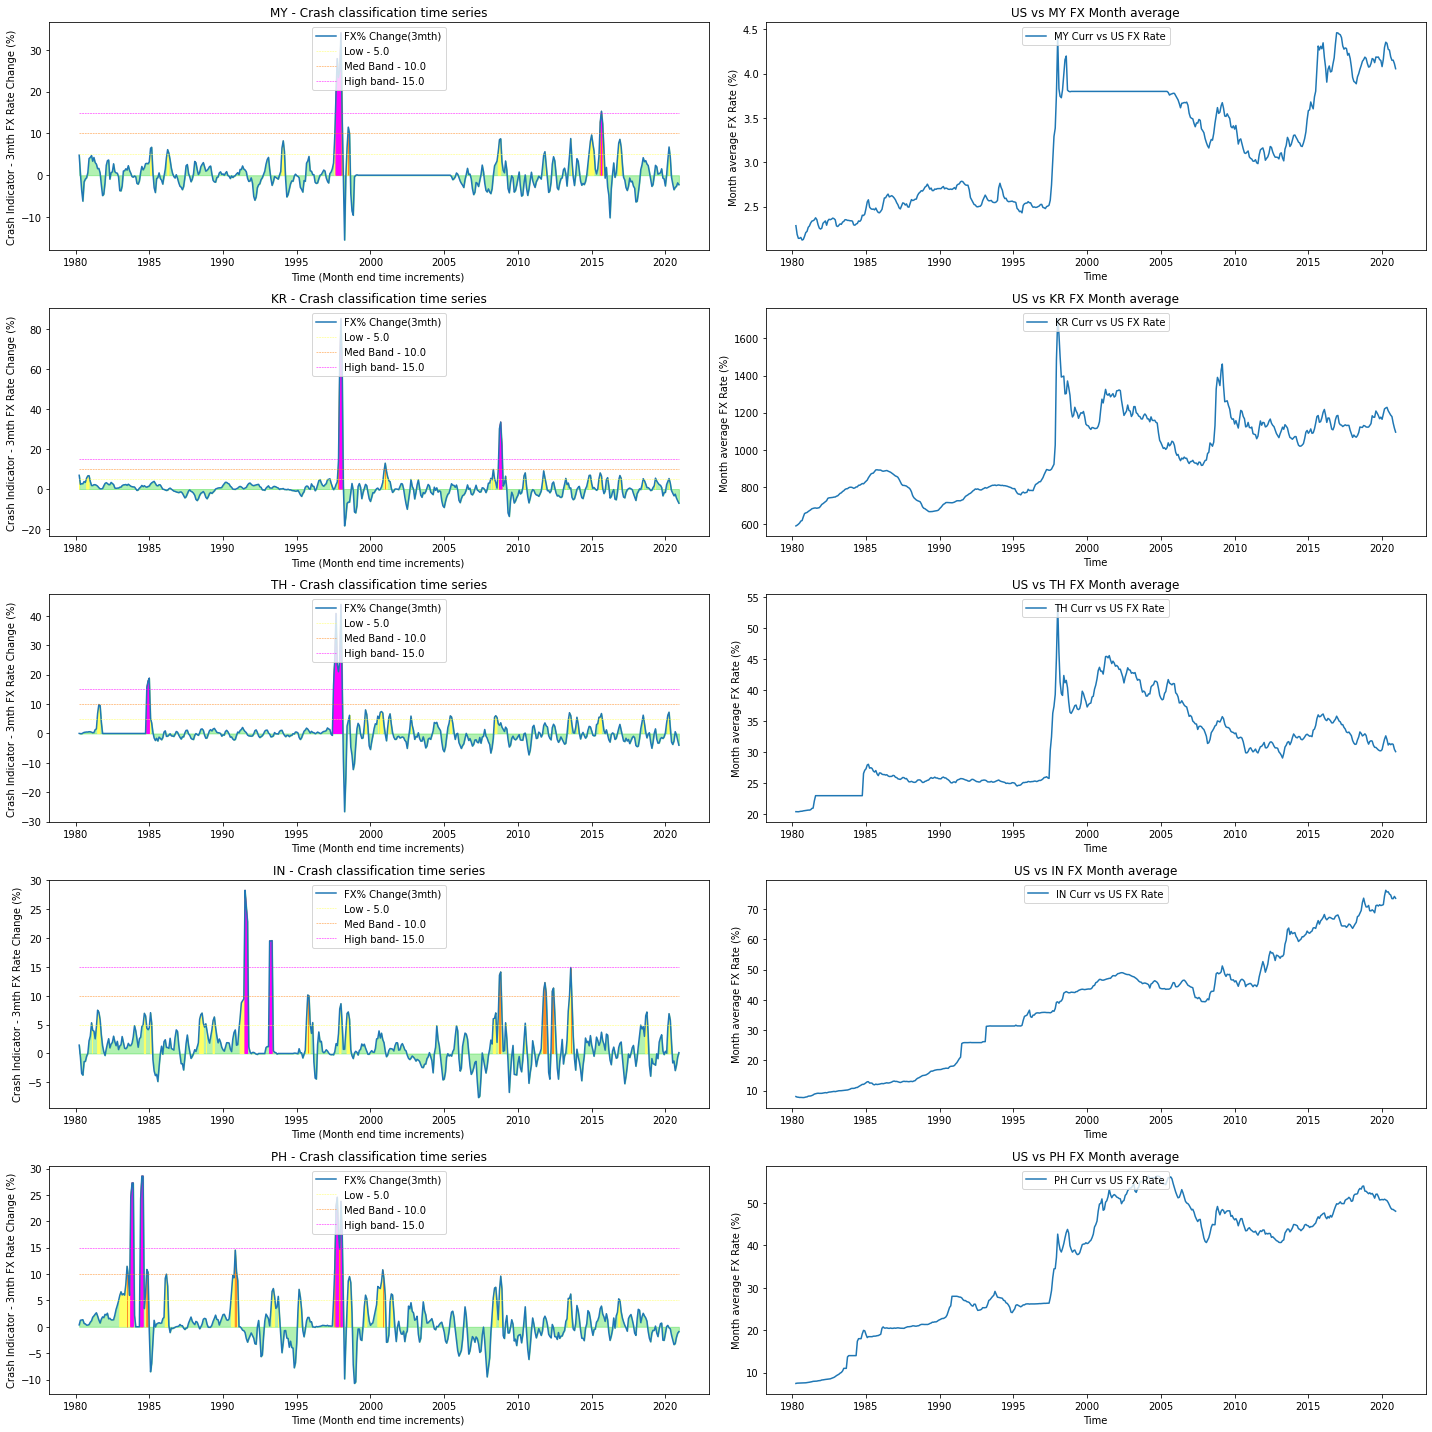

In [ ]:
plot_curr_crash(APAC)

In [ ]:
catrgorical_curr_bar_plot(APAC)

### EMEA

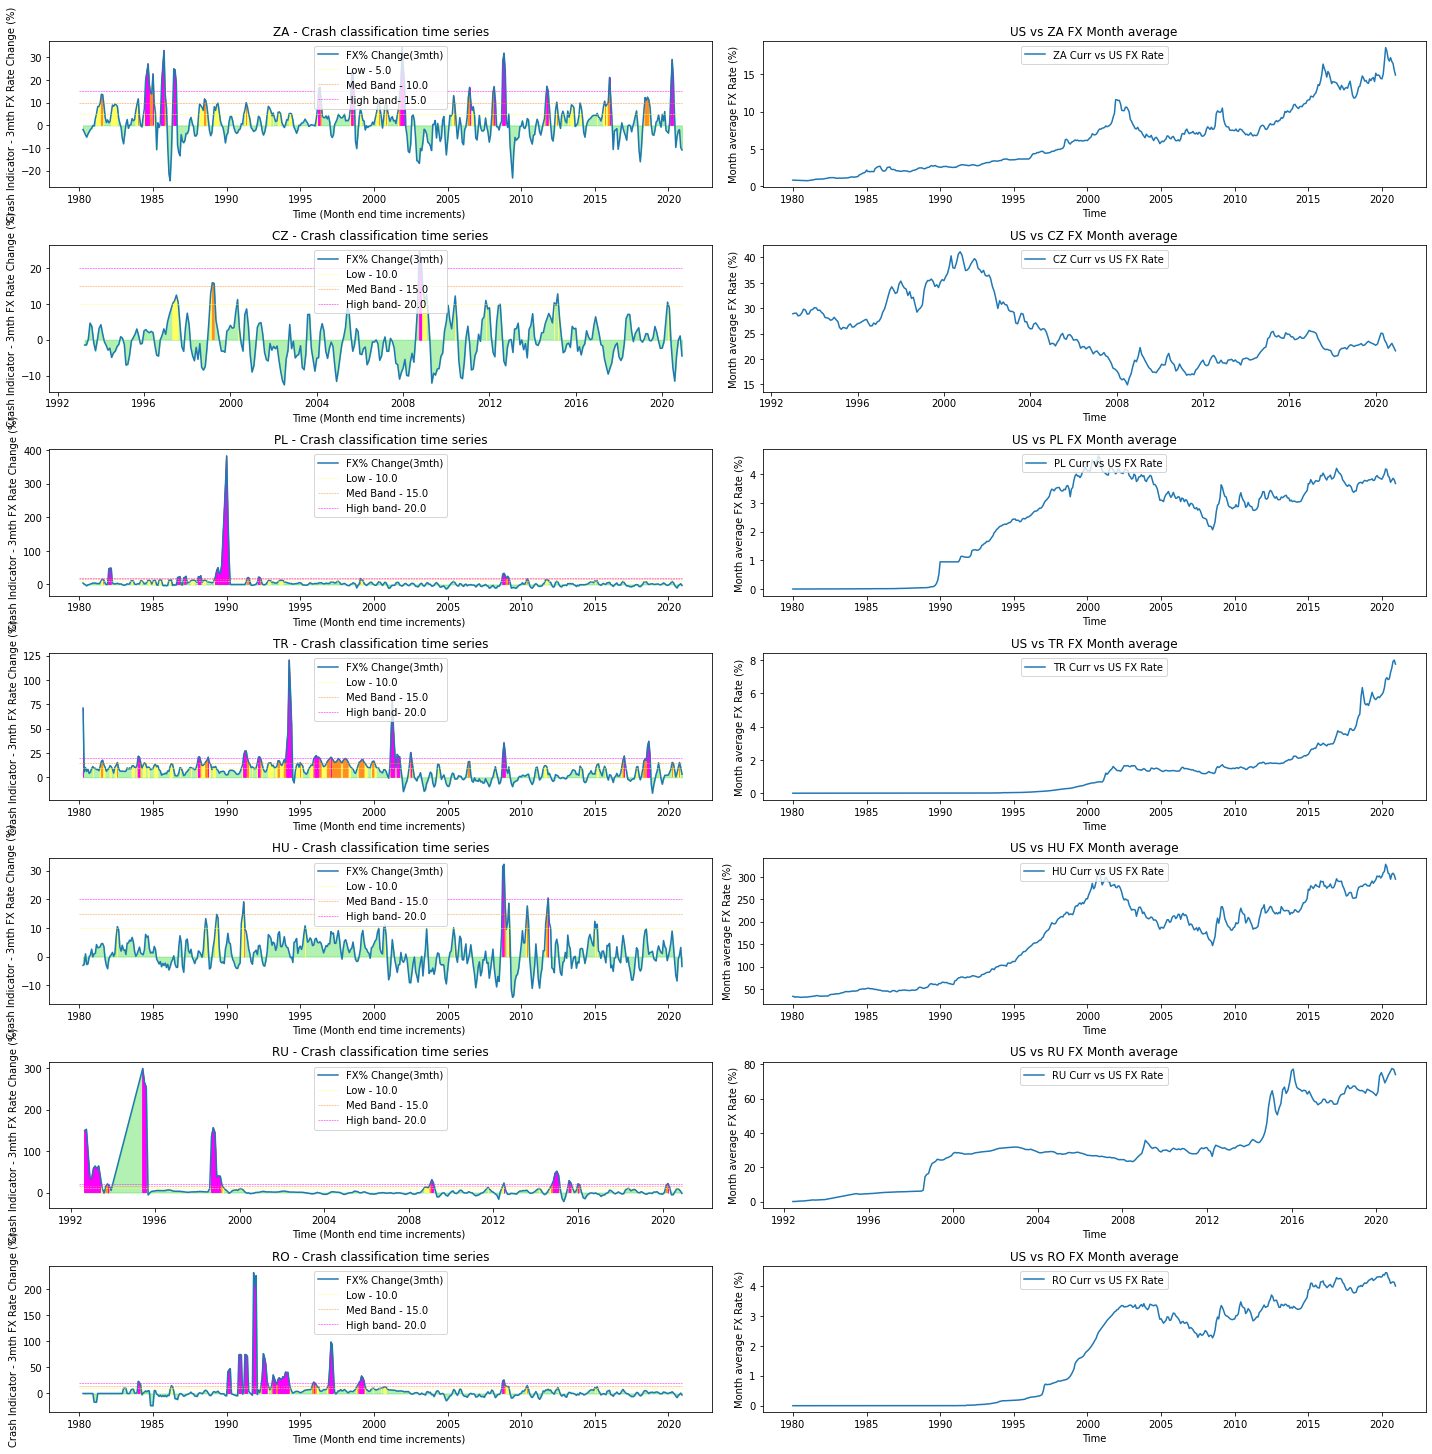

In [ ]:
plot_curr_crash(EMEA)

In [ ]:
catrgorical_curr_bar_plot(EMEA)

### LATM

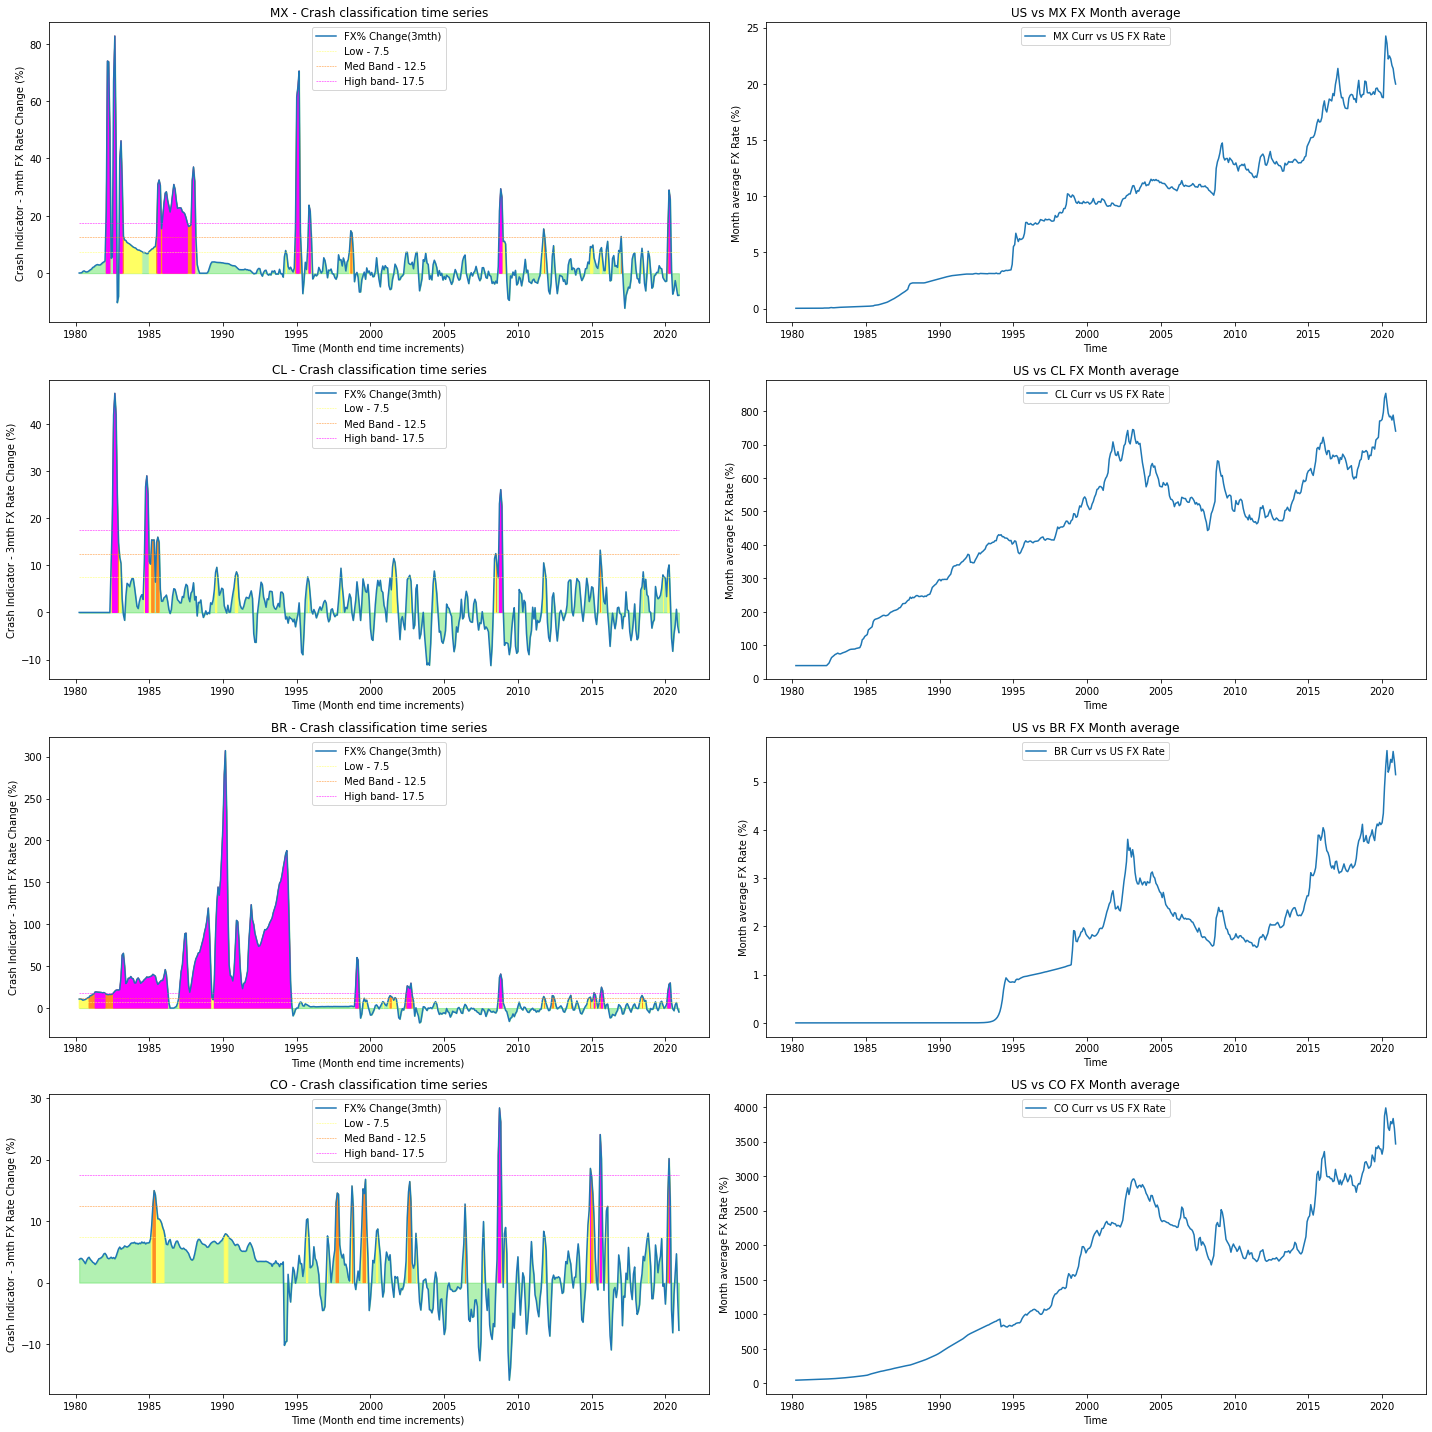

In [ ]:
plot_curr_crash(LATM)

In [ ]:
catrgorical_curr_bar_plot(LATM)

In [ ]:
Full[Full['Country']=='BR']

Year Country  ENDA_XDC_USD_RATE     % Diff  \
7058  1980-01      BR       1.888667e-11        NaN   
7059  1980-02      BR       1.941419e-11        NaN   
7060  1980-03      BR       2.012997e-11        NaN   
7061  1980-04      BR       2.091239e-11  10.725660   
7062  1980-05      BR       2.154680e-11  10.984798   
...       ...     ...                ...        ...   
7545  2020-08      BR       5.460633e+00  -3.229160   
7546  2020-09      BR       5.398881e+00   3.904656   
7547  2020-10      BR       5.625190e+00   6.545858   
7548  2020-11      BR       5.417235e+00  -0.794749   
7549  2020-12      BR       5.144945e+00  -4.703484   

                          region  Level_1  Level_2  Level_3   Min_move  \
7058  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
7059  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
7060  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
7061  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
7062  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
...                          ...      ...      ...      ...        ...   
7545  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
7546  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
7547  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
7548  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   
7549  Latin America & Caribbean       7.5     12.5     17.5 -17.688582   

        Max_move             Class  
7058  307.182201               NaN  
7059  307.182201               NaN  
7060  307.182201               NaN  
7061  307.182201               Low  
7062  307.182201               Low  
...          ...               ...  
7545  307.182201  normal behaviour  
7546  307.182201  normal behaviour  
7547  307.182201  normal behaviour  
7548  307.182201  normal behaviour  
7549  307.182201  normal behaviour  

[492 rows x 11 columns]

In [ ]:
import quandl
quandl.ApiConfig.api_key = "bu8h2aStGXk6JxZRbQd9"
quandl.get("http://www.quandl.com/api/v3/datasets/FRED/DEXMXUS")
#quandl.get("DEXMXUS")

ModuleNotFoundError: No module named 'Quandl'

In [ ]:
fred_rates = pd.DataFrame({'Currency': {'DEXBZUS': 'Brazilian Real (BRL)',
                                        'DEXHKUS': 'Hong Kong Dollar (HKD)',
                                        'DEXINUS': 'Indian Rupee (INR)',
                                        'DEXKOUS': 'South Korean Won (KRW)',
                                        'DEXMAUS': 'Malaysian Ringgit (MYR)',
                                        'DEXMXUS': 'Mexican Peso (MXN)',
                                        'DEXSFUS': 'South African Rand(ZAR)',
                                        'DEXSIUS': 'Singapore Dollar (SGD)',
                                        'DEXSLUS': 'Sri Lankan Rupee(LKR)',
                                        'DEXTHUS': 'Thai Baht (THB)',
                                        'DEXUSUK': 'British Pound (GBP)',
                                        'DEXVZUS': 'Venezuelan Bolivar (VEF)'}})

BOE_rates = pd.DataFrame({'Currency': {'XUDLBK27': 'Czech Koruna (CZK)',
                                       'XUDLBK35': 'Hungarian Forint (HUF)',
                                       'XUDLBK65': 'Israeli Shekel (NIS)',
                                       'XUDLBK69': 'Russian Ruble (RUB)',
                                       'XUDLBK75': 'Turkish Lira (TRY)',
                                        }})
fred_rates['symbol'] = fred_rates.Currency.map(lambda x: x[-4:-1])
BOE_rates['symbol'] = BOE_rates.Currency.map(lambda x: x[-4:-1])

In [ ]:
fred_rates = fred_rates[fred_rates['symbol']=='MXN']
fred_rates

Currency symbol
DEXMXUS  Mexican Peso (MXN)    MXN

In [ ]:
rates1 = [quandl.get("FRED/{0}".format(fx)) for fx in fred_rates.index]
fx_rates = pd.concat(rates1, axis=1)
fx_rates.columns = [fx for fx in fred_rates.symbol]
fx_rates

MXN
Date               
1993-11-08   3.1520
1993-11-09   3.2400
1993-11-10   3.2400
1993-11-12   3.2400
1993-11-15   3.2150
...             ...
2021-07-19  20.0000
2021-07-20  20.1470
2021-07-21  20.1530
2021-07-22  20.1934
2021-07-23  20.0300

[6950 rows x 1 columns]

In [ ]:
rates1 = [quandl.get("FRED/{0}".format(fx)) for fx in fred_rates.index]
rates2 = [quandl.get("BOE/{0}".format(fx)) for fx in BOE_rates.index]
fx_rates = pd.concat(rates1, axis=1)
BOE_fx_rates = pd.concat(rates2, axis=1)
fx_rates.columns = [fx for fx in fred_rates.symbol]
BOE_fx_rates.columns = [fx for fx in BOE_rates.symbol]



In [ ]:
BOE_fx_rates.head(2)

CZK       HUF  NIS  RUB  TRY
Date                                        
2003-10-01  27.2807  216.7662  NaN  NaN  NaN
2003-10-02  27.2636  217.2157  NaN  NaN  NaN

In [ ]:
BOE_fx_rates.tail(2)

CZK       HUF     NIS      RUB     TRY
Date                                                  
2021-07-27  21.7184  303.4334  3.2549  73.6575  8.5633
2021-07-28  21.6822  305.7203  3.2558  73.7425  8.5743

In [ ]:
fx_rates.head(2)

BRL  HKD  INR  KRW     MYR  MXN  ZAR  SGD  LKR  THB     GBP  VEF
Date                                                                        
1971-01-04  NaN  NaN  NaN  NaN  3.0867  NaN  NaN  NaN  NaN  NaN  2.3938  NaN
1971-01-05  NaN  NaN  NaN  NaN  3.0861  NaN  NaN  NaN  NaN  NaN  2.3949  NaN

In [ ]:
pd.merge(fx_rates,BOE_fx_rates,how ='outer',left_index=True, right_index=True)

BRL     HKD    INR      KRW     MYR      MXN      ZAR     SGD  \
Date                                                                           
1971-01-04     NaN     NaN    NaN      NaN  3.0867      NaN      NaN     NaN   
1971-01-05     NaN     NaN    NaN      NaN  3.0861      NaN      NaN     NaN   
1971-01-06     NaN     NaN    NaN      NaN  3.0845      NaN      NaN     NaN   
1971-01-07     NaN     NaN    NaN      NaN  3.0850      NaN      NaN     NaN   
1971-01-08     NaN     NaN    NaN      NaN  3.0845      NaN      NaN     NaN   
...            ...     ...    ...      ...     ...      ...      ...     ...   
2021-07-22  5.2071  7.7702  74.46  1149.99  4.2230  20.1934  14.7275  1.3596   
2021-07-23  5.1766  7.7697  74.44  1153.53  4.2264  20.0300  14.8175  1.3602   
2021-07-26     NaN     NaN    NaN      NaN     NaN      NaN      NaN     NaN   
2021-07-27     NaN     NaN    NaN      NaN     NaN      NaN      NaN     NaN   
2021-07-28     NaN     NaN    NaN      NaN     NaN      NaN      NaN     NaN   

              LKR    THB     GBP          VEF      CZK       HUF     NIS  \
Date                                                                       
1971-01-04    NaN    NaN  2.3938          NaN      NaN       NaN     NaN   
1971-01-05    NaN    NaN  2.3949          NaN      NaN       NaN     NaN   
1971-01-06    NaN    NaN  2.3967          NaN      NaN       NaN     NaN   
1971-01-07    NaN    NaN  2.3963          NaN      NaN       NaN     NaN   
1971-01-08    NaN    NaN  2.3972          NaN      NaN       NaN     NaN   
...           ...    ...     ...          ...      ...       ...     ...   
2021-07-22  199.0  32.88  1.3750  3703417.750  21.7344  303.2567  3.2728   
2021-07-23  199.0  32.95  1.3749  3764258.982  21.7956  306.3850  3.2731   
2021-07-26    NaN    NaN     NaN          NaN  21.7395  306.3093  3.2560   
2021-07-27    NaN    NaN     NaN          NaN  21.7184  303.4334  3.2549   
2021-07-28    NaN    NaN     NaN          NaN  21.6822  305.7203  3.2558   

                RUB     TRY  
Date                         
1971-01-04      NaN     NaN  
1971-01-05      NaN     NaN  
1971-01-06      NaN     NaN  
1971-01-07      NaN     NaN  
1971-01-08      NaN     NaN  
...             ...     ...  
2021-07-22  73.8460  8.5693  
2021-07-23  73.7050  8.5278  
2021-07-26  73.7100  8.5676  
2021-07-27  73.6575  8.5633  
2021-07-28  73.7425  8.5743  

[13094 rows x 17 columns]

In [ ]:
wb.get_countries().reset_index()

id iso2Code                                               name  \
0    ABW       AW                                              Aruba   
1    AFE                                 Africa Eastern and Southern   
2    AFG       AF                                        Afghanistan   
3    AFR       A9                                             Africa   
4    AFW                                  Africa Western and Central   
..   ...      ...                                                ...   
294  XZN       A5  Sub-Saharan Africa excluding South Africa and ...   
295  YEM       YE                                        Yemen, Rep.   
296  ZAF       ZA                                       South Africa   
297  ZMB       ZM                                             Zambia   
298  ZWE       ZW                                           Zimbabwe   

                         region  \
0    Latin America & Caribbean    
1                    Aggregates   
2                    South Asia   
3                    Aggregates   
4                    Aggregates   
..                          ...   
294                  Aggregates   
295  Middle East & North Africa   
296         Sub-Saharan Africa    
297         Sub-Saharan Africa    
298         Sub-Saharan Africa    

                                           adminregion          incomeLevel  \
0                                                               High income   
1                                                                Aggregates   
2                                           South Asia           Low income   
3                                                                Aggregates   
4                                                                Aggregates   
..                                                 ...                  ...   
294                                                              Aggregates   
295  Middle East & North Africa (excluding high inc...           Low income   
296         Sub-Saharan Africa (excluding high income)  Upper middle income   
297         Sub-Saharan Africa (excluding high income)  Lower middle income   
298         Sub-Saharan Africa (excluding high income)  Lower middle income   

        lendingType capitalCity  longitude  latitude  
0    Not classified  Oranjestad   -70.0167   12.5167  
1        Aggregates                    NaN       NaN  
2               IDA       Kabul    69.1761   34.5228  
3        Aggregates                    NaN       NaN  
4        Aggregates                    NaN       NaN  
..              ...         ...        ...       ...  
294      Aggregates                    NaN       NaN  
295             IDA      Sana'a    44.2075   15.3520  
296            IBRD    Pretoria    28.1871  -25.7460  
297             IDA      Lusaka    28.2937  -15.3982  
298           Blend      Harare    31.0672  -17.8312  

[299 rows x 10 columns]

In [15]:
def Get_curr_code(iso2):
    data_url = 'https://datahub.io/core/country-codes/datapackage.json'
    # to load Data Package into storage
    package = datapackage.Package(data_url)
    # to load only tabular data
    resources = package.resources
    for resource in resources:
        if resource.tabular:
            comp_countries = pd.read_csv(resource.descriptor['path'])
    X = comp_countries[['ISO3166-1-Alpha-2','ISO4217-currency_alphabetic_code']]
    curr_code = X['ISO4217-currency_alphabetic_code'][X['ISO3166-1-Alpha-2']==iso2].item()
    return curr_code

def Get_curr_data(iso2):
    curr_code = Get_curr_code(iso2)
    FRED = ['BRL','HKD','INR','KRW','MYR','MXN','ZAR','SGD','LKR','THB','GBP','VEF']
    BOE = ['CZK','HUF','NIS','RUB','TRY']

    if curr_code in FRED: 
        fred_rates = pd.DataFrame({'Currency': {'DEXBZUS': 'Brazilian Real (BRL)',
                                                'DEXHKUS': 'Hong Kong Dollar (HKD)',
                                                'DEXINUS': 'Indian Rupee (INR)',
                                                'DEXKOUS': 'South Korean Won (KRW)',
                                                'DEXMAUS': 'Malaysian Ringgit (MYR)',
                                                'DEXMXUS': 'Mexican Peso (MXN)',
                                                'DEXSFUS': 'South African Rand(ZAR)',
                                                'DEXSIUS': 'Singapore Dollar (SGD)',
                                                'DEXSLUS': 'Sri Lankan Rupee(LKR)',
                                                'DEXTHUS': 'Thai Baht (THB)',
                                                'DEXUSUK': 'British Pound (GBP)',
                                                'DEXVZUS': 'Venezuelan Bolivar (VEF)'}})
        fred_rates['symbol'] = fred_rates.Currency.map(lambda x: x[-4:-1])
        fred_rates = fred_rates[fred_rates['symbol']==curr_code]
        rates1 = [quandl.get("FRED/{0}".format(fx)) for fx in fred_rates.index]
        fx_rates = pd.concat(rates1, axis=1)
        fx_rates.columns = [fx for fx in fred_rates.symbol]



    elif curr_code in BOE:
        BOE_rates = pd.DataFrame({'Currency': {'XUDLBK27': 'Czech Koruna (CZK)',
                                               'XUDLBK35': 'Hungarian Forint (HUF)',
                                               'XUDLBK65': 'Israeli Shekel (NIS)',
                                               'XUDLBK69': 'Russian Ruble (RUB)',
                                               'XUDLBK75': 'Turkish Lira (TRY)',
                                                }})
        BOE_rates['symbol'] = BOE_rates.Currency.map(lambda x: x[-4:-1])
        BOE_rates = BOE_rates[BOE_rates['symbol']==curr_code]
        rates2 = [quandl.get("BOE/{0}".format(fx)) for fx in BOE_rates.index]
        fx_rates = pd.concat(rates2, axis=1)
        fx_rates.columns = [fx for fx in BOE_rates.symbol]
    #fx_rates[curr_code] = 1/fx_rates[curr_code]
    return fx_rates

def generate_time_lags(df, n_lags):
    df_n = df.copy()
    col = df.columns.item()
    for n in range(1, n_lags + 1):
        df_n[f"{col}:T-{n}"] = df_n[col].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

def Get_FX_RNN_Data(iso2, input_dim):
    FX_Rates = Get_curr_data(iso2)
    FX_Rates = generate_time_lags(FX_Rates, n_lags = input_dim)
    return FX_Rates

In [6]:
FX = Get_curr_data('CZ')

In [6]:
FX.reset_index().columns[0]

NameError: name 'FX' is not defined

In [5]:
Add_datetimes(FX, wave = 'N')

NameError: name 'Add_datetimes' is not defined

<AxesSubplot:xlabel='Date'>

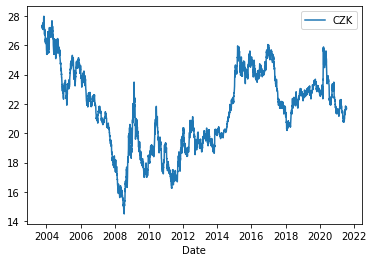

In [ ]:
sns.lineplot(data=FX)

In [ ]:
input_dim = 100

df_generated = generate_time_lags(FX, input_dim)
df_generated

CZK  CZK:T-1  CZK:T-2  CZK:T-3  CZK:T-4  CZK:T-5  CZK:T-6  \
Date                                                                        
2004-02-23  25.9559  25.9010  25.8038  25.5302  25.4796  25.5788  25.4849   
2004-02-24  25.7203  25.9559  25.9010  25.8038  25.5302  25.4796  25.5788   
2004-02-25  25.8504  25.7203  25.9559  25.9010  25.8038  25.5302  25.4796   
2004-02-26  26.0551  25.8504  25.7203  25.9559  25.9010  25.8038  25.5302   
2004-02-27  26.1543  26.0551  25.8504  25.7203  25.9559  25.9010  25.8038   
...             ...      ...      ...      ...      ...      ...      ...   
2021-07-22  21.7344  21.8058  21.8156  21.7584  21.6126  21.6121  21.6853   
2021-07-23  21.7956  21.7344  21.8058  21.8156  21.7584  21.6126  21.6121   
2021-07-26  21.7395  21.7956  21.7344  21.8058  21.8156  21.7584  21.6126   
2021-07-27  21.7184  21.7395  21.7956  21.7344  21.8058  21.8156  21.7584   
2021-07-28  21.6822  21.7184  21.7395  21.7956  21.7344  21.8058  21.8156   

            CZK:T-7  CZK:T-8  CZK:T-9  ...  CZK:T-91  CZK:T-92  CZK:T-93  \
Date                                   ...                                 
2004-02-23  25.5931  25.9041  26.1007  ...   27.4605   27.4901   27.1622   
2004-02-24  25.4849  25.5931  25.9041  ...   27.5215   27.4605   27.4901   
2004-02-25  25.5788  25.4849  25.5931  ...   27.3925   27.5215   27.4605   
2004-02-26  25.4796  25.5788  25.4849  ...   27.3835   27.3925   27.5215   
2004-02-27  25.5302  25.4796  25.5788  ...   27.2546   27.3835   27.3925   
...             ...      ...      ...  ...       ...       ...       ...   
2021-07-22  21.6975  21.6566  21.6983  ...   21.8764   22.0520   22.0999   
2021-07-23  21.6853  21.6975  21.6566  ...   21.9300   21.8764   22.0520   
2021-07-26  21.6121  21.6853  21.6975  ...   21.9705   21.9300   21.8764   
2021-07-27  21.6126  21.6121  21.6853  ...   21.9623   21.9705   21.9300   
2021-07-28  21.7584  21.6126  21.6121  ...   21.9647   21.9623   21.9705   

            CZK:T-94  CZK:T-95  CZK:T-96  CZK:T-97  CZK:T-98  CZK:T-99  \
Date                                                                     
2004-02-23   27.3453   27.1242   27.1478   27.3101   27.3758   27.2636   
2004-02-24   27.1622   27.3453   27.1242   27.1478   27.3101   27.3758   
2004-02-25   27.4901   27.1622   27.3453   27.1242   27.1478   27.3101   
2004-02-26   27.4605   27.4901   27.1622   27.3453   27.1242   27.1478   
2004-02-27   27.5215   27.4605   27.4901   27.1622   27.3453   27.1242   
...              ...       ...       ...       ...       ...       ...   
2021-07-22   22.2651   22.1399   21.7774   21.6665   21.7077   21.6853   
2021-07-23   22.0999   22.2651   22.1399   21.7774   21.6665   21.7077   
2021-07-26   22.0520   22.0999   22.2651   22.1399   21.7774   21.6665   
2021-07-27   21.8764   22.0520   22.0999   22.2651   22.1399   21.7774   
2021-07-28   21.9300   21.8764   22.0520   22.0999   22.2651   22.1399   

            CZK:T-100  
Date                   
2004-02-23    27.2807  
2004-02-24    27.2636  
2004-02-25    27.3758  
2004-02-26    27.3101  
2004-02-27    27.1478  
...               ...  
2021-07-22    21.5718  
2021-07-23    21.6853  
2021-07-26    21.7077  
2021-07-27    21.6665  
2021-07-28    21.7774  

[4408 rows x 101 columns]

In [ ]:
Get_FX_RNN_Data('MX', 50)

MXN  MXN:T-1  MXN:T-2  MXN:T-3  MXN:T-4  MXN:T-5  MXN:T-6  \
Date                                                                        
1994-01-25   3.1055   3.1060   3.1060   3.1065   3.1060   3.1060   3.1085   
1994-01-26   3.1070   3.1055   3.1060   3.1060   3.1065   3.1060   3.1060   
1994-01-27   3.1062   3.1070   3.1055   3.1060   3.1060   3.1065   3.1060   
1994-01-28   3.1050   3.1062   3.1070   3.1055   3.1060   3.1060   3.1065   
1994-01-31   3.1060   3.1050   3.1062   3.1070   3.1055   3.1060   3.1060   
...             ...      ...      ...      ...      ...      ...      ...   
2021-07-19  20.0000  19.8380  19.9280  19.8920  19.9910  19.8440  19.8810   
2021-07-20  20.1470  20.0000  19.8380  19.9280  19.8920  19.9910  19.8440   
2021-07-21  20.1530  20.1470  20.0000  19.8380  19.9280  19.8920  19.9910   
2021-07-22  20.1934  20.1530  20.1470  20.0000  19.8380  19.9280  19.8920   
2021-07-23  20.0300  20.1934  20.1530  20.1470  20.0000  19.8380  19.9280   

            MXN:T-7  MXN:T-8  MXN:T-9  ...  MXN:T-41  MXN:T-42  MXN:T-43  \
Date                                   ...                                 
1994-01-25   3.1060   3.1095   3.1090  ...    3.1030    3.1026    3.1022   
1994-01-26   3.1085   3.1060   3.1095  ...    3.1140    3.1030    3.1026   
1994-01-27   3.1060   3.1085   3.1060  ...    3.1100    3.1140    3.1030   
1994-01-28   3.1060   3.1060   3.1085  ...    3.1055    3.1100    3.1140   
1994-01-31   3.1065   3.1060   3.1060  ...    3.1038    3.1055    3.1100   
...             ...      ...      ...  ...       ...       ...       ...   
2021-07-19  19.9650  19.9870  19.9840  ...   19.8000   19.8280   19.8000   
2021-07-20  19.8810  19.9650  19.9870  ...   19.8770   19.8000   19.8280   
2021-07-21  19.8440  19.8810  19.9650  ...   19.9400   19.8770   19.8000   
2021-07-22  19.9910  19.8440  19.8810  ...   19.8630   19.9400   19.8770   
2021-07-23  19.8920  19.9910  19.8440  ...   19.8880   19.8630   19.9400   

            MXN:T-44  MXN:T-45  MXN:T-46  MXN:T-47  MXN:T-48  MXN:T-49  \
Date                                                                     
1994-01-25    3.1150    3.1080    3.2150    3.2400     3.240     3.240   
1994-01-26    3.1022    3.1150    3.1080    3.2150     3.240     3.240   
1994-01-27    3.1026    3.1022    3.1150    3.1080     3.215     3.240   
1994-01-28    3.1030    3.1026    3.1022    3.1150     3.108     3.215   
1994-01-31    3.1140    3.1030    3.1026    3.1022     3.115     3.108   
...              ...       ...       ...       ...       ...       ...   
2021-07-19   19.8600   20.0460   20.1160   19.8550    19.870    19.901   
2021-07-20   19.8000   19.8600   20.0460   20.1160    19.855    19.870   
2021-07-21   19.8280   19.8000   19.8600   20.0460    20.116    19.855   
2021-07-22   19.8000   19.8280   19.8000   19.8600    20.046    20.116   
2021-07-23   19.8770   19.8000   19.8280   19.8000    19.860    20.046   

            MXN:T-50  
Date                  
1994-01-25     3.152  
1994-01-26     3.240  
1994-01-27     3.240  
1994-01-28     3.240  
1994-01-31     3.215  
...              ...  
2021-07-19    20.177  
2021-07-20    19.901  
2021-07-21    19.870  
2021-07-22    19.855  
2021-07-23    20.116  

[6900 rows x 51 columns]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5afecb5f-7d28-4b37-ae51-8d94c0fa9663' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>